In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/Labelled_Multiclass_Dataset'
os.chdir(project_path)

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Labelled_Multiclass_Dataset/combined_data_with_okpVacc_modified.csv')

In [5]:
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
drop_columns = [
    "id"
   ]
data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

In [7]:
# Ensure the index is of datetime type
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data['time'] = pd.to_datetime(data['timestamp'])
    data.set_index('time', inplace=True)

In [8]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? False


In [9]:
# If the index is not sorted, sort it
if not is_sorted:
    data.sort_index(inplace=True)
    print("Timestamp index was not sorted. It has now been sorted.")

Timestamp index was not sorted. It has now been sorted.


In [10]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? True


In [11]:
# Identifying missing values
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [12]:
# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [13]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 0
Missing values after processing infinite values: 0


In [14]:
# Define window size  and step size
window_size = pd.Timedelta('5s')  # 5-second window size
step_size = pd.Timedelta('1s')   # 1-second sliding step

In [15]:
# Ensure 'timestamp' is included in the dataset
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

# Aggregate session-based features and add timestamp information
session_data = data.groupby(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']).agg(
    # Session-based aggregations
    flow_duration=('flow_duration', 'sum'),
    total_forward_packets=('tot_fwd_pkts', 'sum'),
    total_backward_packets=('tot_bwd_pkts', 'sum'),
    total_bytes_forward=('totlen_fwd_pkts', 'sum'),
    total_bytes_backward=('totlen_bwd_pkts', 'sum'),
    mean_packet_length_forward=('fwd_pkt_len_mean', 'mean'),
    mean_packet_length_backward=('bwd_pkt_len_mean', 'mean'),
    packet_size_mean=('pkt_len_mean', 'mean'),
    flow_iat_mean=('flow_iat_mean', 'mean'),
    down_up_ratio=('down_up_ratio', 'mean'),
    subflow_fwd_pkts=('subflow_fwd_pkts', 'sum'),
    subflow_bwd_pkts=('subflow_bwd_pkts', 'sum'),
    subflow_fwd_byts=('subflow_fwd_byts', 'sum'),
    subflow_bwd_byts=('subflow_bwd_byts', 'sum'),

    # Direction-specific aggregations (Forward flows)
    fwd_pkt_len_mean=('fwd_pkt_len_mean', 'mean'),
    fwd_pkt_len_max=('fwd_pkt_len_max', 'max'),
    fwd_pkt_len_min=('fwd_pkt_len_min', 'min'),
    fwd_pkt_len_std=('fwd_pkt_len_std', 'std'),
    fwd_iat_mean=('fwd_iat_mean', 'mean'),
    fwd_iat_max=('fwd_iat_max', 'max'),
    fwd_iat_min=('fwd_iat_min', 'min'),
    fwd_iat_tot=('fwd_iat_tot', 'sum'),
    fwd_blk_rate_avg=('fwd_blk_rate_avg', 'mean'),

    # Direction-specific aggregations (Backward flows)
    bwd_pkt_len_mean=('bwd_pkt_len_mean', 'mean'),
    bwd_pkt_len_max=('bwd_pkt_len_max', 'max'),
    bwd_pkt_len_min=('bwd_pkt_len_min', 'min'),
    bwd_pkt_len_std=('bwd_pkt_len_std', 'std'),
    bwd_iat_mean=('bwd_iat_mean', 'mean'),
    bwd_iat_max=('bwd_iat_max', 'max'),
    bwd_iat_min=('bwd_iat_min', 'min'),
    bwd_iat_tot=('bwd_iat_tot', 'sum'),
    bwd_blk_rate_avg=('bwd_blk_rate_avg', 'mean'),

    # Total packets and bytes
    total_packets=('tot_fwd_pkts', lambda x: x.sum() + data['tot_bwd_pkts'].sum()),
    total_bytes=('totlen_fwd_pkts', lambda x: x.sum() + data['totlen_bwd_pkts'].sum()),

    # Timestamp info: min and max timestamp per session
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
).reset_index()

In [16]:
import scipy.stats

# entropy calculation
def entropy(column):
    counts = column.value_counts(normalize=True)
    return scipy.stats.entropy(counts)

# Time-Based Sliding Window Aggregation
def sliding_window_aggregation(data, window_size, step_size):
    window_aggregates = []

    # Generate the start times using pd.date_range
    start_times = pd.date_range(start=data.index.min(), end=data.index.max(), freq=step_size)

    # Iterate over each time window
    for start_time in start_times:
        end_time = start_time + window_size
        window = data[(data.index >= start_time) & (data.index < end_time)]

        if len(window) == 0:
            continue

        # Ensure timestamp is a datetime object
        window.loc[:, 'timestamp'] = pd.to_datetime(window['timestamp'])


        # Flow rate features (Packets and Bytes per Second)
        duration = (window['timestamp'].max() - window['timestamp'].min()).total_seconds() + 1e-9  # Avoid division by zero
        flow_rate_features = {
            'flow_rate_packets_window': len(window) / duration,
            'flow_rate_bytes_window': window['totlen_fwd_pkts'].sum() / duration,
        }

        # Directional ratio features
        directional_features = {
            'flow_direction_ratio_window': window['tot_fwd_pkts'].sum() / (window['tot_bwd_pkts'].sum() + 1),
            'byte_direction_ratio_window': window['totlen_fwd_pkts'].sum() / (window['totlen_bwd_pkts'].sum() + 1),
        }


        # Entropy-based features (IP Entropy)
        entropy_features = {
            'src_ip_entropy_window': entropy(window['src_ip']),
            'dst_ip_entropy_window': entropy(window['dst_ip']),
        }


        # Combine all features into the aggregated dictionary
        aggregated = {


            'start_time': start_time,
            'end_time': end_time,

            'total_forward_packets_window': window['tot_fwd_pkts'].sum(),
            'total_backward_packets_window': window['tot_bwd_pkts'].sum(),
            'total_forward_bytes_window': window['totlen_fwd_pkts'].sum(),
            'total_backward_bytes_window': window['totlen_bwd_pkts'].sum(),
            'average_packet_size_fwd_window': window['fwd_pkt_len_mean'].mean(),
            'average_packet_size_bwd_window': window['bwd_pkt_len_mean'].mean(),
            'flow_duration_window': window['flow_duration'].sum(),
            'packet_count_window': len(window),
            # IAT Statistics for Forward and Backward Directions
            'mean_iat_fwd_window': window['fwd_iat_mean'].mean(),
            'stddev_iat_fwd_window': window['fwd_iat_std'].mean(),
            'min_iat_fwd_window': window['fwd_iat_min'].min(),
            'max_iat_fwd_window': window['fwd_iat_max'].max(),
            'mean_iat_bwd_window': window['bwd_iat_mean'].mean(),
            'stddev_iat_bwd_window': window['bwd_iat_std'].mean(),
            'min_iat_bwd_window': window['bwd_iat_min'].min(),
            'max_iat_bwd_window': window['bwd_iat_max'].max(),
            **flow_rate_features,
            **directional_features,
            **entropy_features
        }


        window_aggregates.append(aggregated)

    return pd.DataFrame(window_aggregates)

In [17]:
# Apply sliding window aggregation
sliding_windows_data = sliding_window_aggregation(data, window_size, step_size)

In [18]:
sliding_windows_data.columns

Index(['start_time', 'end_time', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window'],
      dtype='object')

In [19]:
sliding_windows_data.head()

,start_time,end_time,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,1.125551e+06,713083.007093,0,55409580,1.260000e+11,2.821800e+13,1.641509,2.397451,0.567192,0.971967
1,2024-08-13 08:00:56,2024-08-13 08:01:01,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
2,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
3,2024-08-13 08:00:58,2024-08-13 08:01:03,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
4,2024-08-13 08:00:59,2024-08-13 08:01:04,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615


In [20]:
# Temporal features
# Calculate the time difference
sliding_windows_data['time_diff'] = sliding_windows_data['end_time'] - sliding_windows_data['start_time']

In [21]:
# convert the difference to seconds
sliding_windows_data['time_diff_seconds'] = sliding_windows_data['time_diff'].dt.total_seconds()

In [22]:
# Merge sliding window and session data on overlapping time intervals
aggregated_data = pd.merge_asof(
    sliding_windows_data.sort_values('start_time'),
    session_data.sort_values('start_time'),
    left_on='start_time',
    right_on='start_time',
    direction='backward'
)

In [23]:
aggregated_data.columns

Index(['start_time', 'end_time_x', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window', 'time_diff',
       'time_diff_seconds', 'src_ip', 'dst_ip', 'src_port', 'dst_port',
       'protocol', 'flow_duration', 'total_forward_packets',
       'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward',
       'mean_packet_length_forward', 'mean_packet_length_backward',
       'packet_si

In [24]:
print(len(session_data))
print(len(sliding_windows_data))
print(len(aggregated_data))

58852
23986
23986


In [25]:
print(session_data.shape)
print(sliding_windows_data.shape)
print(aggregated_data.shape)

(58852, 41)
(23986, 26)
(23986, 66)


In [26]:
# Select columns (src_ip, dst_ip, and Label) from the original DataFrame
original_subset = data[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'Label']].drop_duplicates()

In [27]:
# Perform the merge
aggregated_data = aggregated_data.merge(original_subset, on=['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol'], how='left')

In [28]:
num_rows = aggregated_data.shape[0]
print(f"Number of rows in aggregated_data: {num_rows}")

Number of rows in aggregated_data: 23986


In [29]:
# Check for Class Imbalance
print(aggregated_data['Label'].value_counts())

Label
Benign        23156
TCPAttack       270
UDPAttack       265
HTTPAttack      165
XMasAttack      130
Name: count, dtype: int64


In [30]:
aggregated_data.head()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,end_time_y,Label
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00,XMasAttack
1,2024-08-13 08:00:56,2024-08-13 08:01:01,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00,XMasAttack
2,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00,XMasAttack
3,2024-08-13 08:00:58,2024-08-13 08:01:03,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00,XMasAttack
4,2024-08-13 08:00:59,2024-08-13 08:01:04,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00,XMasAttack


In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
aggregated_data['Attack Number'] = le.fit_transform(aggregated_data['Label'])

print(aggregated_data['Attack Number'].unique())

[4 0 2 3 1]


In [33]:
encoded_values = aggregated_data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: HTTPAttack
2: TCPAttack
3: UDPAttack
4: XMasAttack


In [34]:
correlation = aggregated_data.corr(numeric_only = True).round(2)
correlation.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)

,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,mean_iat_fwd_window,stddev_iat_fwd_window,min_iat_fwd_window,max_iat_fwd_window,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window,time_diff_seconds,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,mean_packet_length_forward,mean_packet_length_backward,packet_size_mean,flow_iat_mean,down_up_ratio,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,fwd_pkt_len_mean,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_std,fwd_iat_mean,fwd_iat_max,fwd_iat_min,fwd_iat_tot,fwd_blk_rate_avg,bwd_pkt_len_mean,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,Attack Number
total_forward_packets_window,1.00,0.27,0.97,0.32,0.04,0.58,0.17,0.10,-0.04,-0.01,-0.00,0.02,0.00,0.03,-0.00,0.06,0.10,0.97,-0.03,-0.03,0.06,0.28,nan,-0.02,-0.05,-0.01,-0.00,0.01,0.02,0.01,0.02,-0.02,0.05,0.00,-0.00,0.04,0.01,0.02,0.01,0.02,-0.02,0.00,-0.03,0.02,-0.00,-0.00,-0.00,-0.00,0.02,0.05,0.03,0.11,0.00,-0.00,-0.00,0.01,-0.00,0.02,0.01,0.01,0.00
total_backward_packets_window,0.27,1.00,0.20,0.99,0.01,0.16,0.04,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,0.20,-0.03,-0.02,0.03,0.08,nan,-0.02,-0.04,0.00,0.00,0.15,0.20,0.15,0.20,0.00,0.09,0.05,-0.00,0.20,0.15,0.20,0.15,0.20,0.00,0.02,-0.01,0.38,0.00,0.00,-0.00,0.00,0.20,0.09,0.03,0.16,0.08,-0.00,-0.00,0.00,0.00,0.20,0.15,0.15,-0.00
total_forward_bytes_window,0.97,0.20,1.00,0.24,0.07,0.56,0.14,0.05,-0.02,-0.00,-0.00,0.02,0.01,0.03,-0.00,0.05,0.05,1.00,-0.04,-0.03,0.03,0.25,nan,-0.02,-0.03,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.02,-0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.04,0.02,0.10,-0.00,-0.00,-0.00,0.01,-0.00,0.00,0.00,0.00,-0.01
total_backward_bytes_window,0.32,0.99,0.24,1.00,0.02,0.22,0.05,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,0.24,-0.02,-0.02,0.03,0.09,nan,-0.02,-0.04,0.00,0.00,0.14,0.19,0.15,0.19,0.01,0.08,0.05,-0.00,0.20,0.14,0.19,0.15,0.19,0.01,0.02,-0.01,0.34,0.00,0.00,0.00,0.00,0.19,0.08,0.02,0.16,0.07,-0.00,-0.00,0.00,0.00,0.19,0.14,0.15,-0.00
average_packet_size_fwd_window,0.04,0.01,0.07,0.02,1.00,0.05,0.12,-0.82,0.42,0.43,-0.03,0.04,0.13,0.16,-0.03,-0.03,-0.82,0.07,-0.13,0.11,-0.05,-0.03,nan,0.11,0.55,0.12,0.00,-0.00,-0.01,0.00,-0.01,0.58,-0.01,0.47,0.00,-0.05,-0.00,-0.01,0.00,-0.01,0.58,0.17,0.63,-0.01,0.00,0.01,0.02,0.00,-0.01,-0.01,-0.01,-0.04,-0.00,0.00,0.00,0.02,0.00,-0.01,-0.00,0.00,-0.16
average_packet_size_bwd_window,0.58,0.16,0.56,0.22,0.05,1.00,0.14,0.14,-0.04,0.04,0.08,0.02,0.16,0.18,0.08,0.16,0.14,0.56,-0.25,-0.23,0.11,0.40,nan,-0.11,-0.17,-0.19,0.00,0.01,0.02,0.02,0.02,0.05,0.25,0.12,0.03,0.15,0.01,0.02,0.02,0.02,0.05,0.08,-0.04,0.03,0.03,0.04,0.12,0.00,0.02,0.25,0.15,0.35,0.01,0.03,0.07,0.16,0.00,0.02,0.01,0.02,0.08
flow_duration_window,0.17,0.04,0.14,0.05,0.12,0.14,1.00,0.10,0.48,0.45,-0.02,0.57,0.20,0.22,-0.02,0.40,0.10,0.14,-0.01,0.01,0.66,0.60,nan,0.00,0.01,0.00,0.01,0.02,0.02,0.02,0.02,0.01,0.00,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.02,0.03,0.01,0.02,-0.02,0.01,0.02,0.00,-0.00,0.02,0.02,0.01,0.01,-0.02,0.01,0.02,0.02,0.02,0.00
packet_count_window,0.10,0.01,0.05,0.01,-0.82,0.14,0.10,1.00,-0.40,-0.32,-0.03,0.07,-0.19,-0.20,-0.03,0.04,1.00,0.05,0.19,-0.02,0.14,0.15,nan,-0.12,-0.52,-0.18,-0.01,-0.01,0.00,-0.01,0.00,-0.50,0.05,-0.40,-0.01,0.07,-0.01,0.00,-0.01,0.00,-0.50,-0.14,-0.55,0.00,-0.01,-0.01,-0.00,-0.01,0.00,0.05,0.03,0.10,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,-0.01,-0.01,0.20
mean_iat_fwd_window,-0.04,-0.01,-0.02,-0.01,0.42,-0.04,0.48,-0.40,1

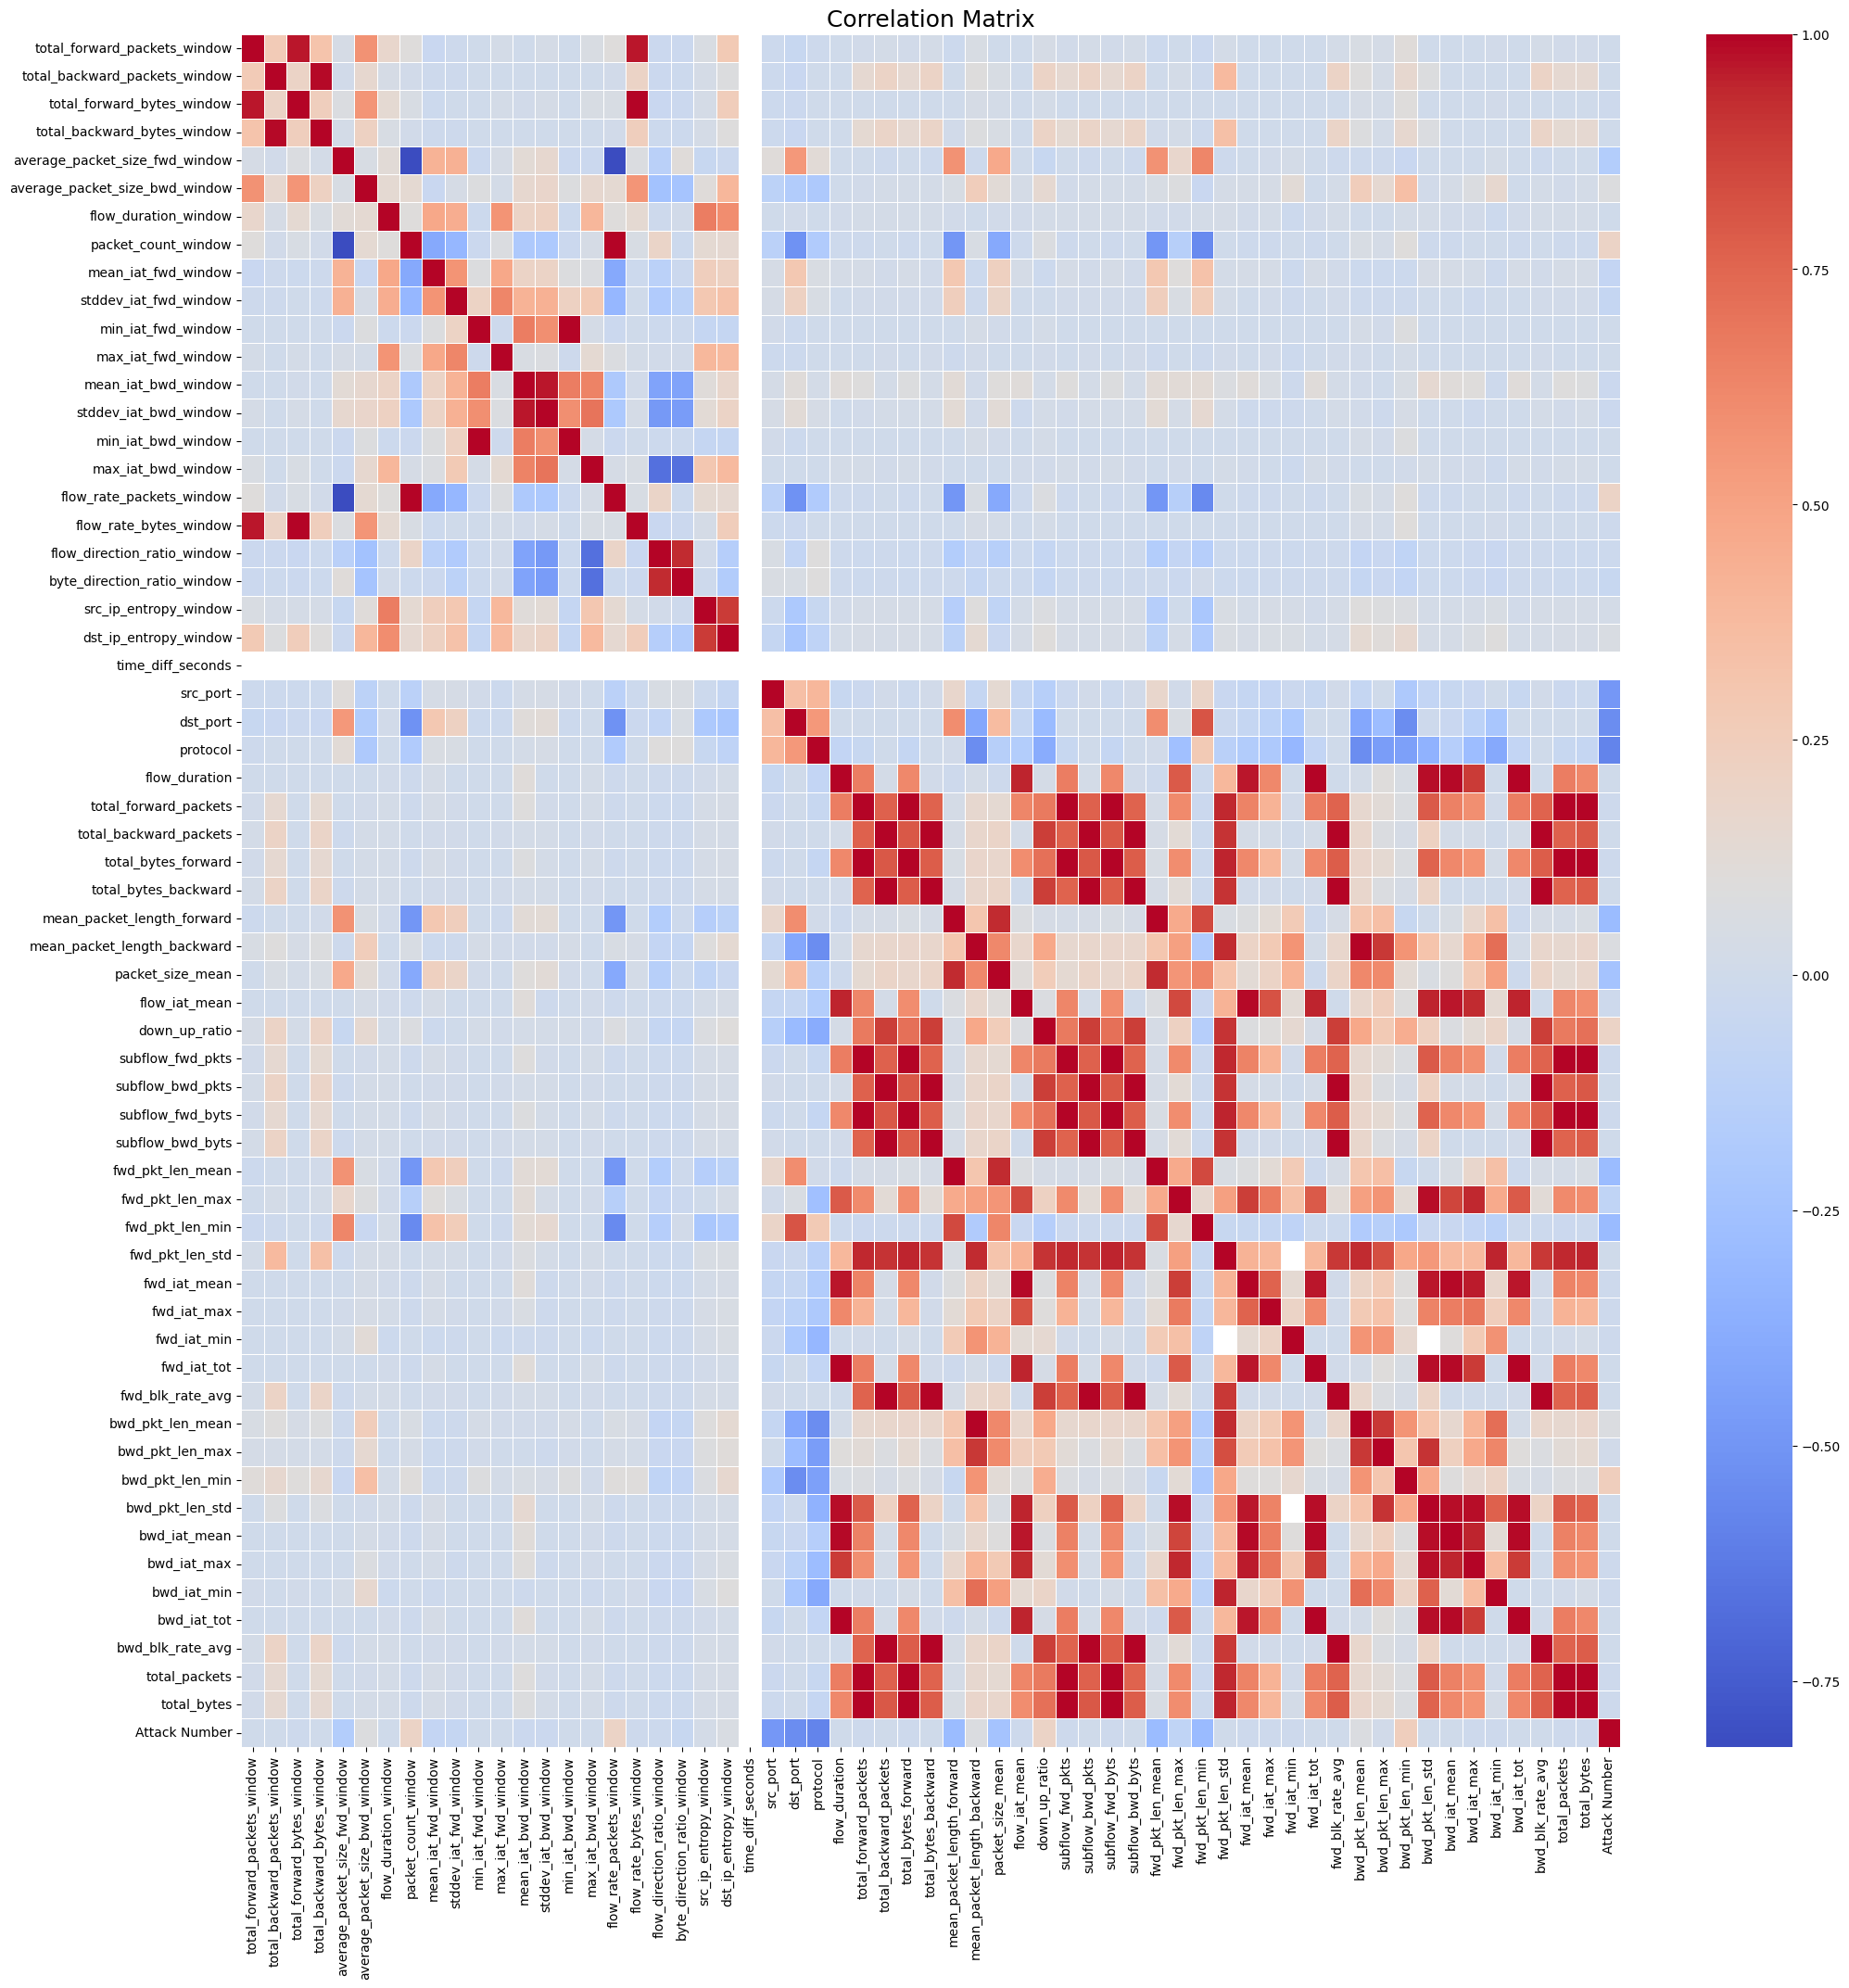

In [35]:
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(correlation, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

In [36]:
# Positive correlation features w.r.t Attacks
positive_correlation = correlation['Attack Number'][(correlation['Attack Number'] > 0) & (correlation['Attack Number'] < 1)].index.tolist()

print("Positive correlation features w.r.t Attacks:\n")
for i, features in enumerate(positive_correlation, start = 1):
    correlation_value = correlation.loc[features, 'Attack Number']
    print('{:<3} {:<24} :{}'.format(f'{i}.', features, correlation_value))

Positive correlation features w.r.t Attacks:

1.  average_packet_size_bwd_window :0.08
2.  packet_count_window      :0.2
3.  flow_rate_packets_window :0.2
4.  src_ip_entropy_window    :0.02
5.  dst_ip_entropy_window    :0.06
6.  mean_packet_length_backward :0.07
7.  down_up_ratio            :0.2
8.  bwd_pkt_len_mean         :0.07
9.  bwd_pkt_len_max          :0.01
10. bwd_pkt_len_min          :0.24


In [37]:
print(f'No of important features: {len(positive_correlation)}')

No of important features: 10


In [38]:
# Columns with zero standard deviation
std = aggregated_data.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
zero_std_cols

['time_diff_seconds']

In [40]:
# Printing the unique value count
indent = '{:<3} {:<30}: {}'
print('Unique value count on Data: ')
for i, feature in enumerate(list(aggregated_data.columns)[:-1], start = 1):
    print(indent.format(f'{i}.', feature, aggregated_data[feature].nunique()))

Unique value count on Data: 
1.  start_time                    : 23986
2.  end_time_x                    : 23986
3.  total_forward_packets_window  : 190
4.  total_backward_packets_window : 101
5.  total_forward_bytes_window    : 3690
6.  total_backward_bytes_window   : 343
7.  average_packet_size_fwd_window: 3674
8.  average_packet_size_bwd_window: 802
9.  flow_duration_window          : 4597
10. packet_count_window           : 123
11. mean_iat_fwd_window           : 4560
12. stddev_iat_fwd_window         : 4553
13. min_iat_fwd_window            : 3
14. max_iat_fwd_window            : 4091
15. mean_iat_bwd_window           : 1977
16. stddev_iat_bwd_window         : 1980
17. min_iat_bwd_window            : 3
18. max_iat_bwd_window            : 1628
19. flow_rate_packets_window      : 123
20. flow_rate_bytes_window        : 3690
21. flow_direction_ratio_window   : 761
22. byte_direction_ratio_window   : 4068
23. src_ip_entropy_window         : 1237
24. dst_ip_entropy_window         : 107

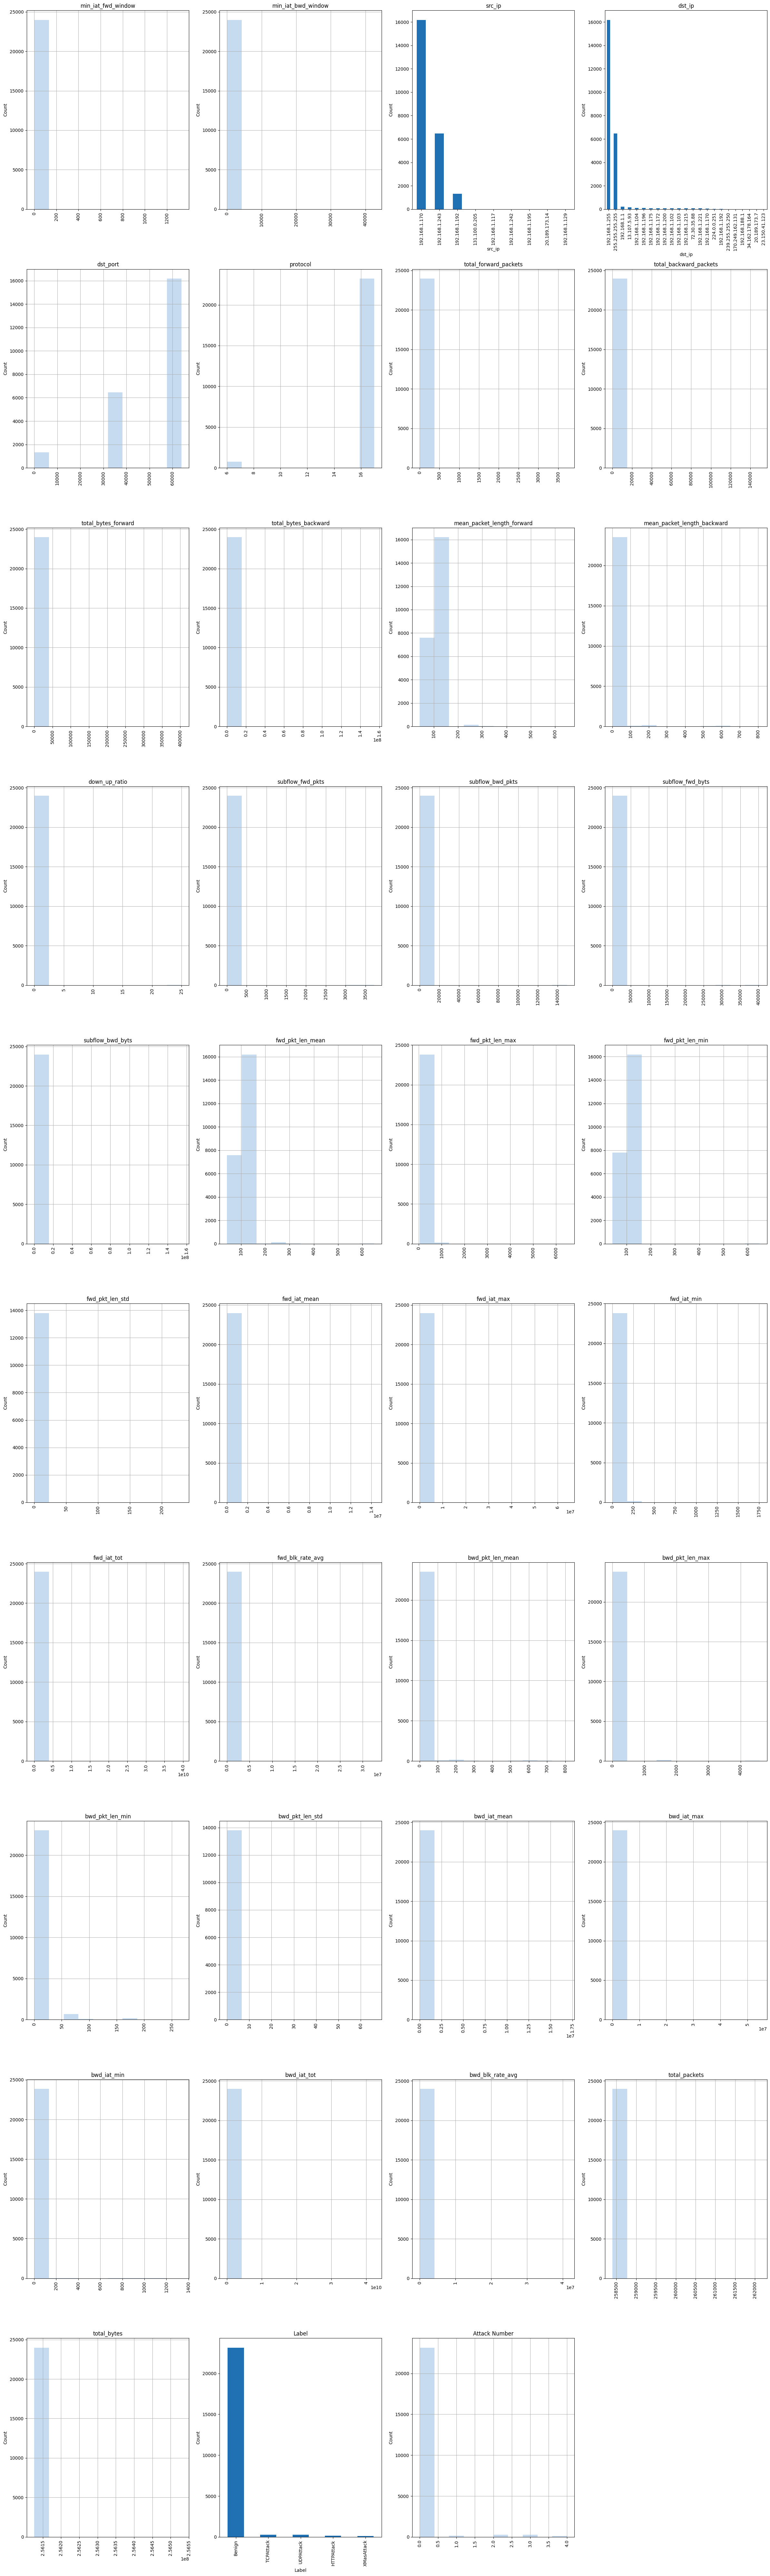

In [41]:
unique_values = aggregated_data.nunique()
selected_cols = aggregated_data[[col for col in aggregated_data if 1 < unique_values[col] < 50]]
rows, cols = selected_cols.shape
col_names = list(selected_cols)
num_of_rows = (cols + 3) // 4

color_palette = sns.color_palette('Blues', n_colors = 3)
plt.figure(figsize = (6 * 4, 8 * num_of_rows))

for i in range(cols):
    plt.subplot(num_of_rows, 4, i + 1)
    col_data = selected_cols.iloc[:, i]
    if col_data.dtype.name == 'object':
        col_data.value_counts().plot(kind = 'bar', color = color_palette[2])
    else:
        col_data.hist(color = color_palette[0])

    plt.ylabel('Count')
    plt.xticks(rotation = 90)
    plt.title(col_names[i])

plt.tight_layout()
plt.show()

In [42]:
cols = aggregated_data.select_dtypes(include=[np.number]).columns
high_corr_pairs = []
corr_th = 0.85

# Compute correlations for numeric columns only
for i in range(len(cols)):
  for j in range(i + 1, len(cols)):
    val = aggregated_data[cols[i]].corr(aggregated_data[cols[j]])
    # If the correlation coefficient is NaN or below the threshold, skip to the next pair
    if np.isnan(val) or val < corr_th:
      continue
    high_corr_pairs.append((val, cols[i], cols[j]))

# Set up plot dimensions based on the number of correlation pairs
size, cols = len(high_corr_pairs), 4
rows, rem =  size // cols, size % cols
if rem:
  rows += 1

fig, axs = plt.subplots(rows, cols, figsize = (24, int(size * 1.7)))
for i in range(rows):
    for j in range(cols):
      try:
        val, x, y = high_corr_pairs[i * cols + j]
        if val > 0.99:
          axs[i, j].scatter(aggregated_data[x], aggregated_data[y], color = 'green', alpha = 0.1)
        else:
          axs[i, j].scatter(aggregated_data[x], aggregated_data[y], color = 'blue', alpha = 0.1)
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)
        axs[i, j].set_title(f'{x} vs\n{y} ({val:.2f})')
      except IndexError:
        fig.delaxes(axs[i, j])

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:
aggregated_data.drop('Attack Number', axis = 1, inplace = True)

In [44]:
# Identifying outliers
numeric_data = aggregated_data.select_dtypes(include = ['float', 'int'])
q1 = numeric_data.quantile(0.25)
q3 = numeric_data.quantile(0.75)
iqr = q3 - q1
outlier = (numeric_data < (q1 - 1.5 * iqr)) | (numeric_data > (q3 + 1.5 * iqr))
outlier_count = outlier.sum()
outlier_percentage = round(outlier.mean() * 100, 2)
outlier_stats = pd.concat([outlier_count, outlier_percentage], axis = 1)
outlier_stats.columns = ['Outlier Count', 'Outlier Percentage']
print(outlier_stats)

                                Outlier Count  Outlier Percentage
total_forward_packets_window              461                1.92
total_backward_packets_window            1131                4.72
total_forward_bytes_window                236                0.98
total_backward_bytes_window              1756                7.32
average_packet_size_fwd_window             10                0.04
average_packet_size_bwd_window           1901                7.93
flow_duration_window                      196                0.82
packet_count_window                       666                2.78
mean_iat_fwd_window                       285                1.19
stddev_iat_fwd_window                     720                3.00
min_iat_fwd_window                         10                0.04
max_iat_fwd_window                        460                1.92
mean_iat_bwd_window                       175                0.73
stddev_iat_bwd_window                      80                0.33
min_iat_bw

In [45]:
# Identifying outliers based on attack type
outlier_counts = {}
for i in numeric_data:
    for label in aggregated_data['Label'].unique():
        attack_data = aggregated_data[i][aggregated_data['Label'] == label]
        q1, q3 = np.percentile(attack_data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = ((attack_data < lower_bound) | (attack_data > upper_bound)).sum()
        outlier_percent = num_outliers / len(attack_data) * 100
        outlier_counts[(i, label)] = (num_outliers, outlier_percent)

for i in numeric_data:
  print(f'Feature: {i}')
  for label in aggregated_data['Label'].unique():
    num_outliers, outlier_percent = outlier_counts[(i, label)]
    print(f'- {label}: {num_outliers} ({outlier_percent:.2f}%)')
  print()

Feature: total_forward_packets_window
- XMasAttack: 6 (4.62%)
- Benign: 434 (1.87%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 5 (1.89%)
- HTTPAttack: 0 (0.00%)

Feature: total_backward_packets_window
- XMasAttack: 25 (19.23%)
- Benign: 867 (3.74%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 12 (4.53%)
- HTTPAttack: 0 (0.00%)

Feature: total_forward_bytes_window
- XMasAttack: 3 (2.31%)
- Benign: 222 (0.96%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 1 (0.38%)
- HTTPAttack: 0 (0.00%)

Feature: total_backward_bytes_window
- XMasAttack: 12 (9.23%)
- Benign: 1482 (6.40%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 38 (14.34%)
- HTTPAttack: 26 (15.76%)

Feature: average_packet_size_fwd_window
- XMasAttack: 0 (0.00%)
- Benign: 10 (0.04%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 0 (0.00%)
- HTTPAttack: 4 (2.42%)

Feature: average_packet_size_bwd_window
- XMasAttack: 0 (0.00%)
- Benign: 1549 (6.69%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 45 (16.98%)
- HTTPAttack: 0 (0.00%)

Feature: flow_duration_window
- XMasAttack: 1 (0.77%)
- B

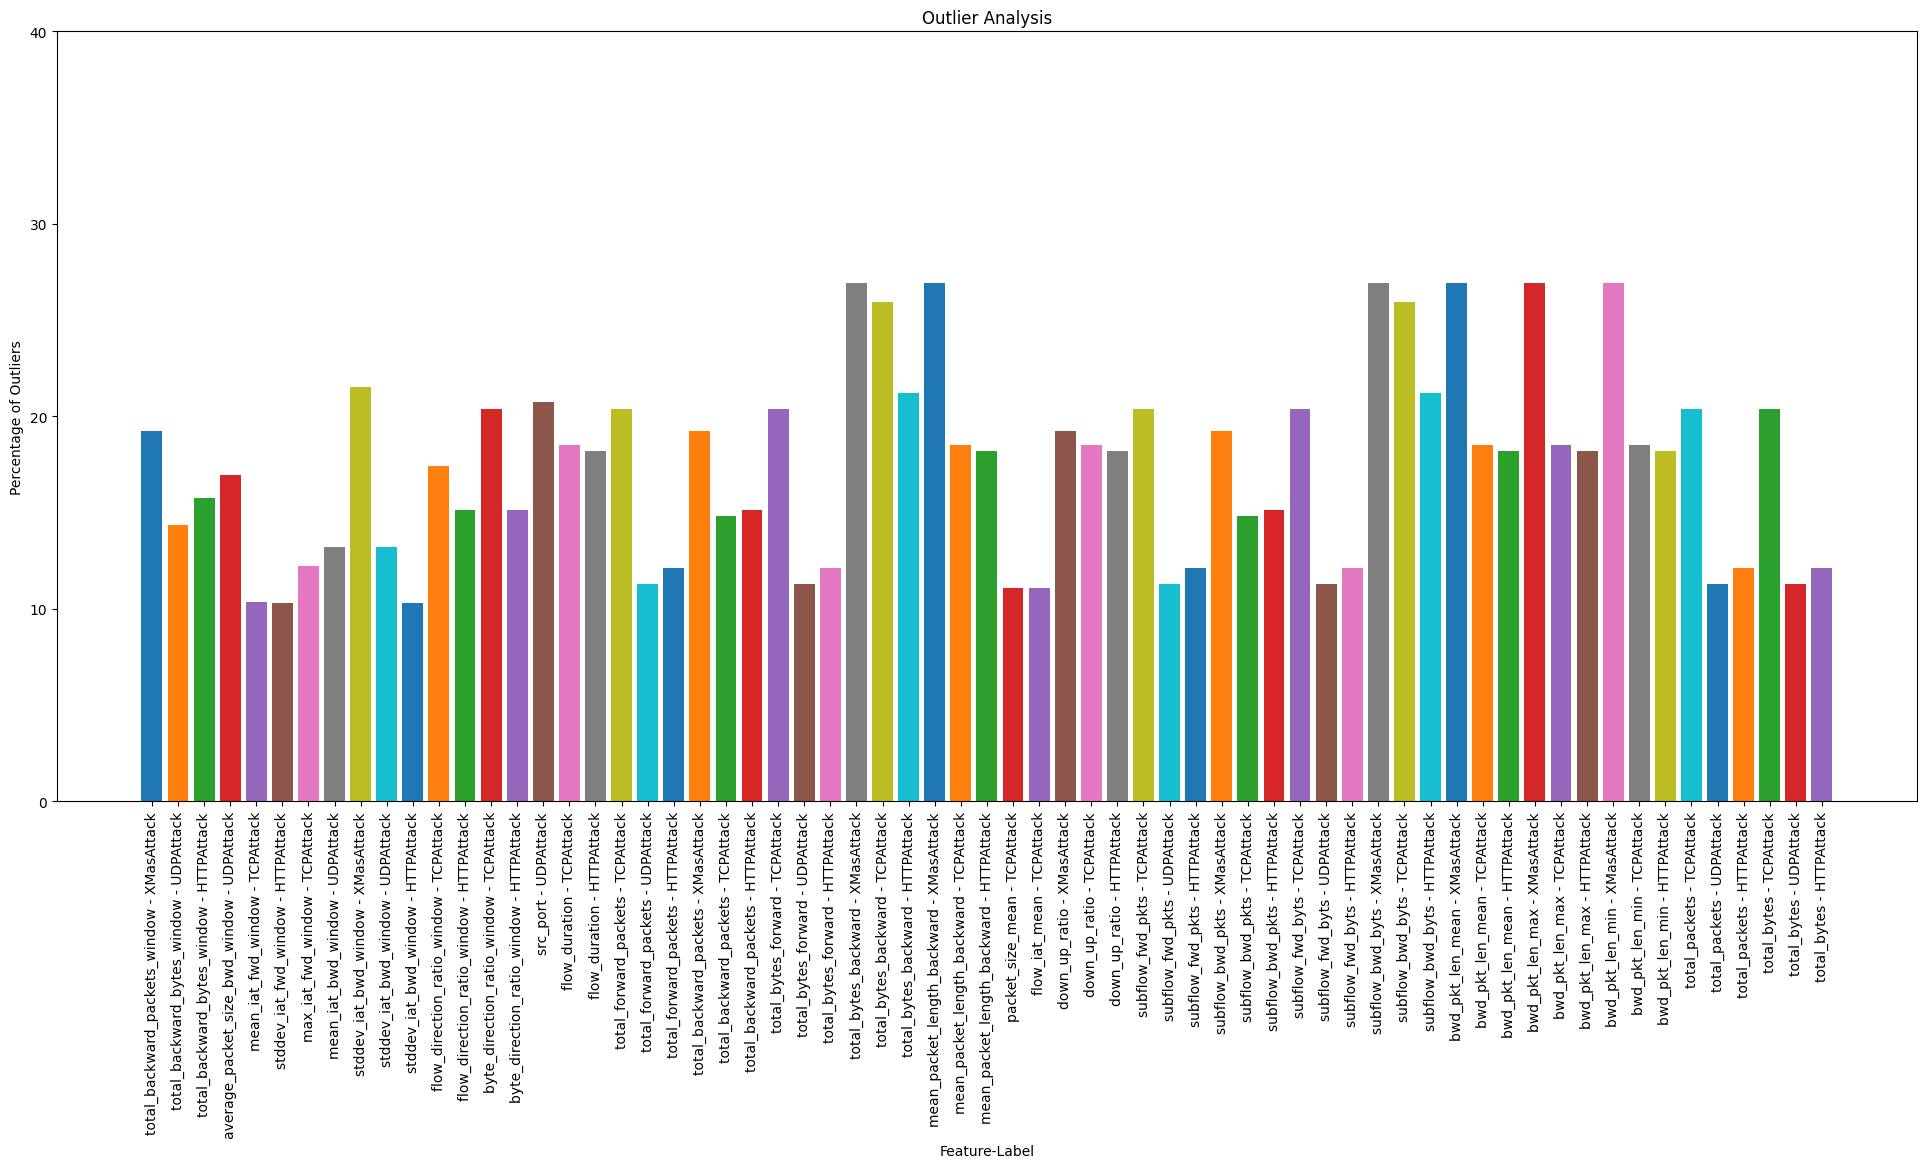

In [46]:
# Plotting the percentage of outliers that are higher than 20%
fig, ax = plt.subplots(figsize = (24, 10))
for i in numeric_data:
    for label in aggregated_data['Label'].unique():
        num_outliers, outlier_percent = outlier_counts[(i, label)]
        if outlier_percent > 10:
            ax.bar(f'{i} - {label}', outlier_percent)

ax.set_xlabel('Feature-Label')
ax.set_ylabel('Percentage of Outliers')
ax.set_title('Outlier Analysis')
ax.set_yticks(np.arange(0, 41, 10))
plt.xticks(rotation = 90)
plt.show()

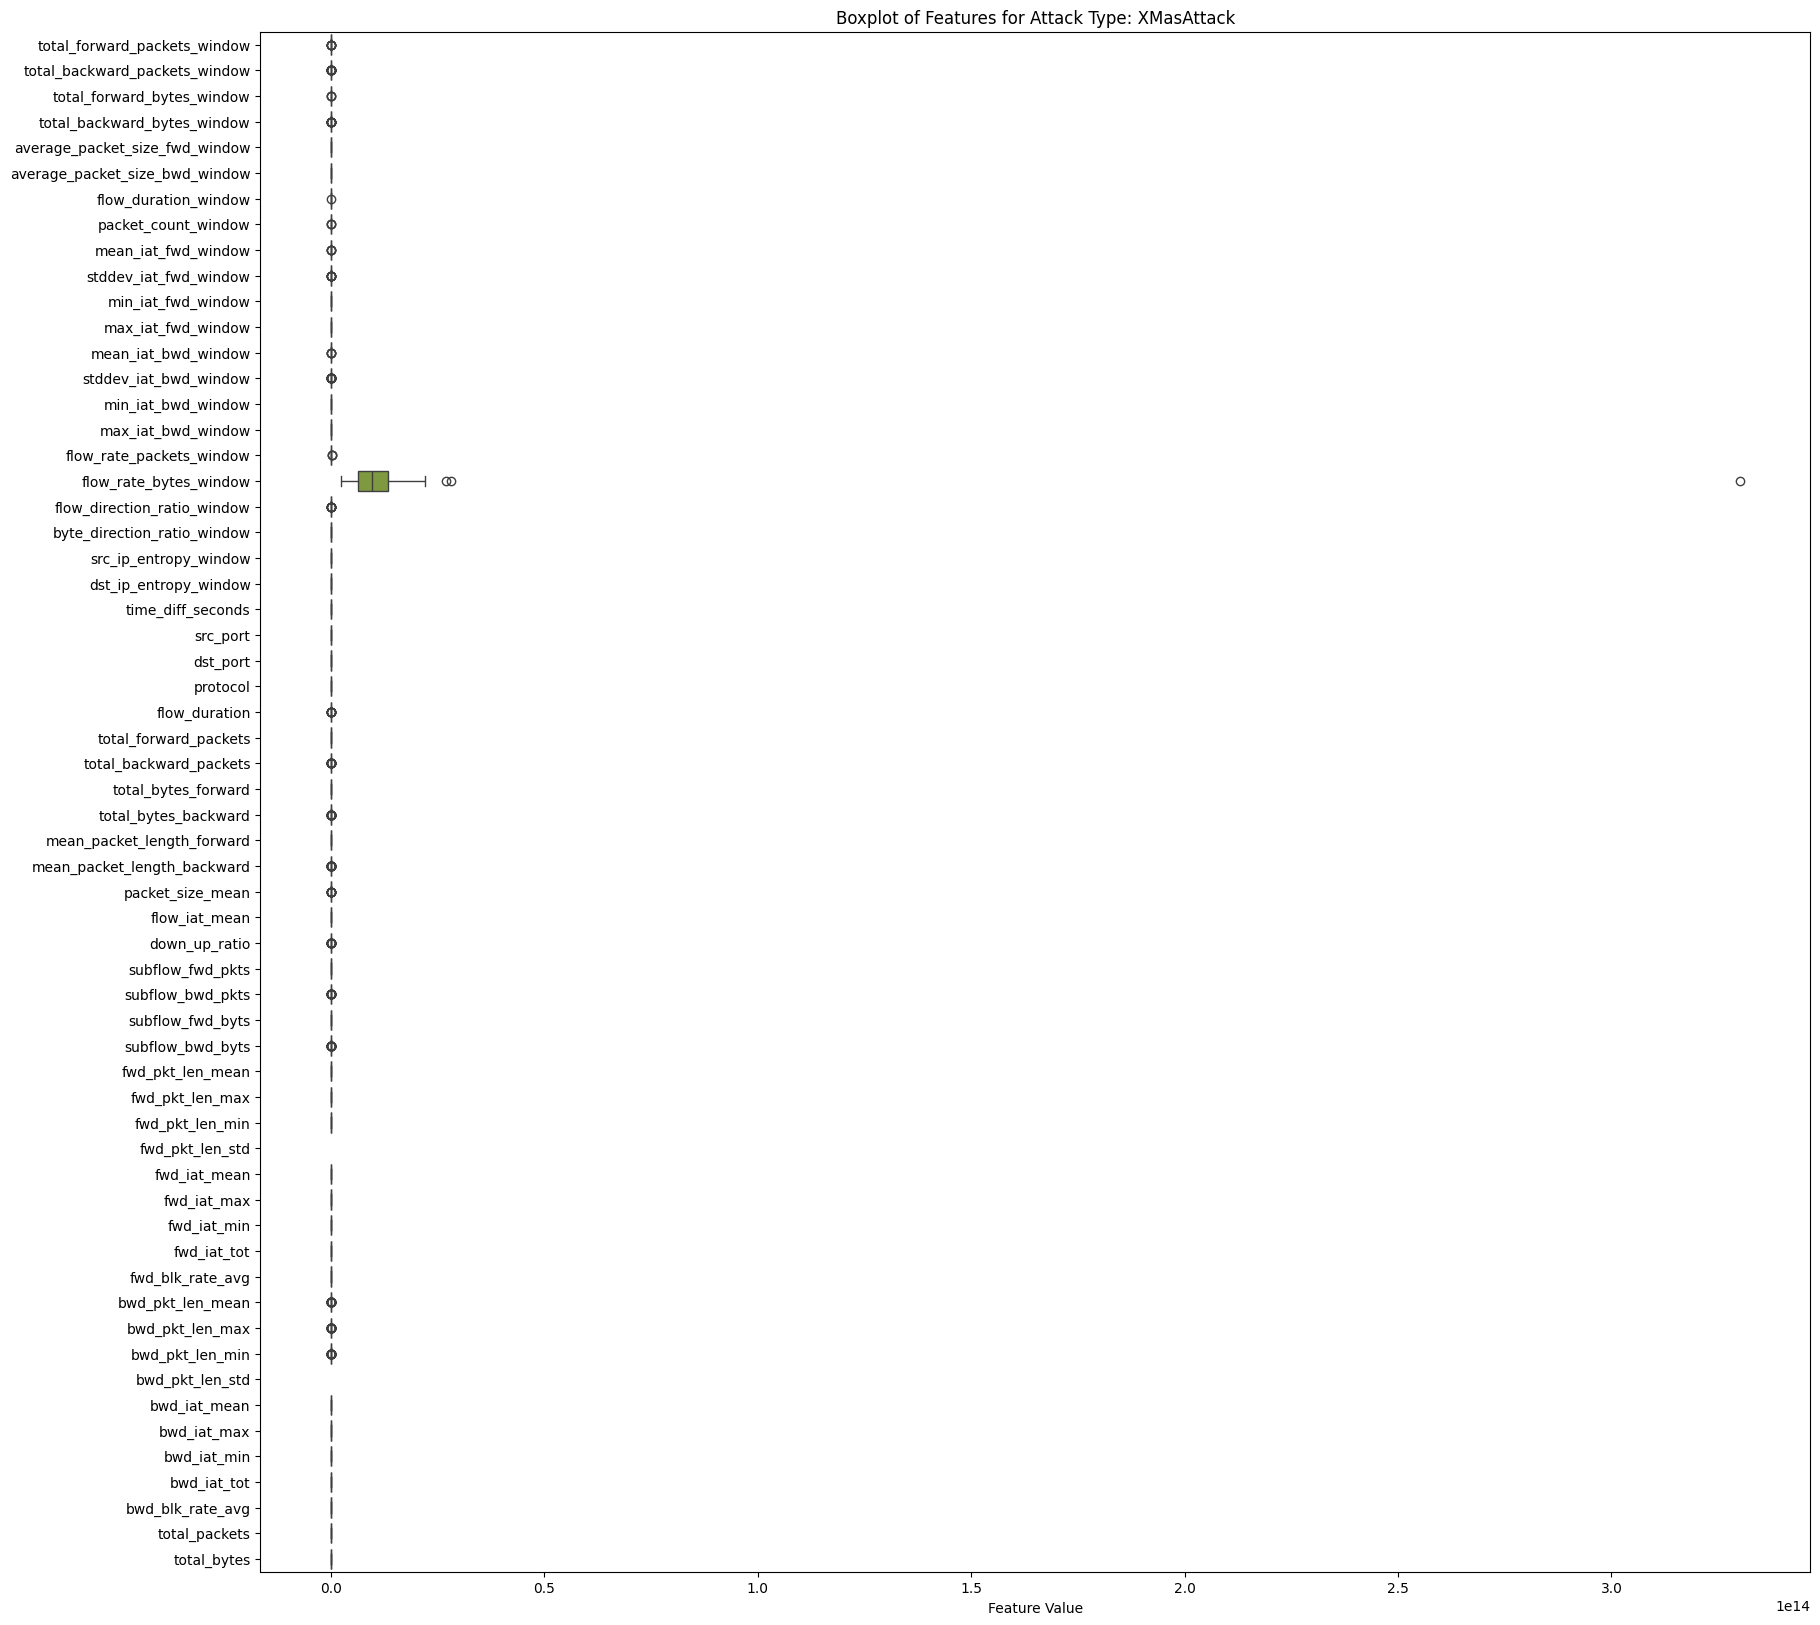

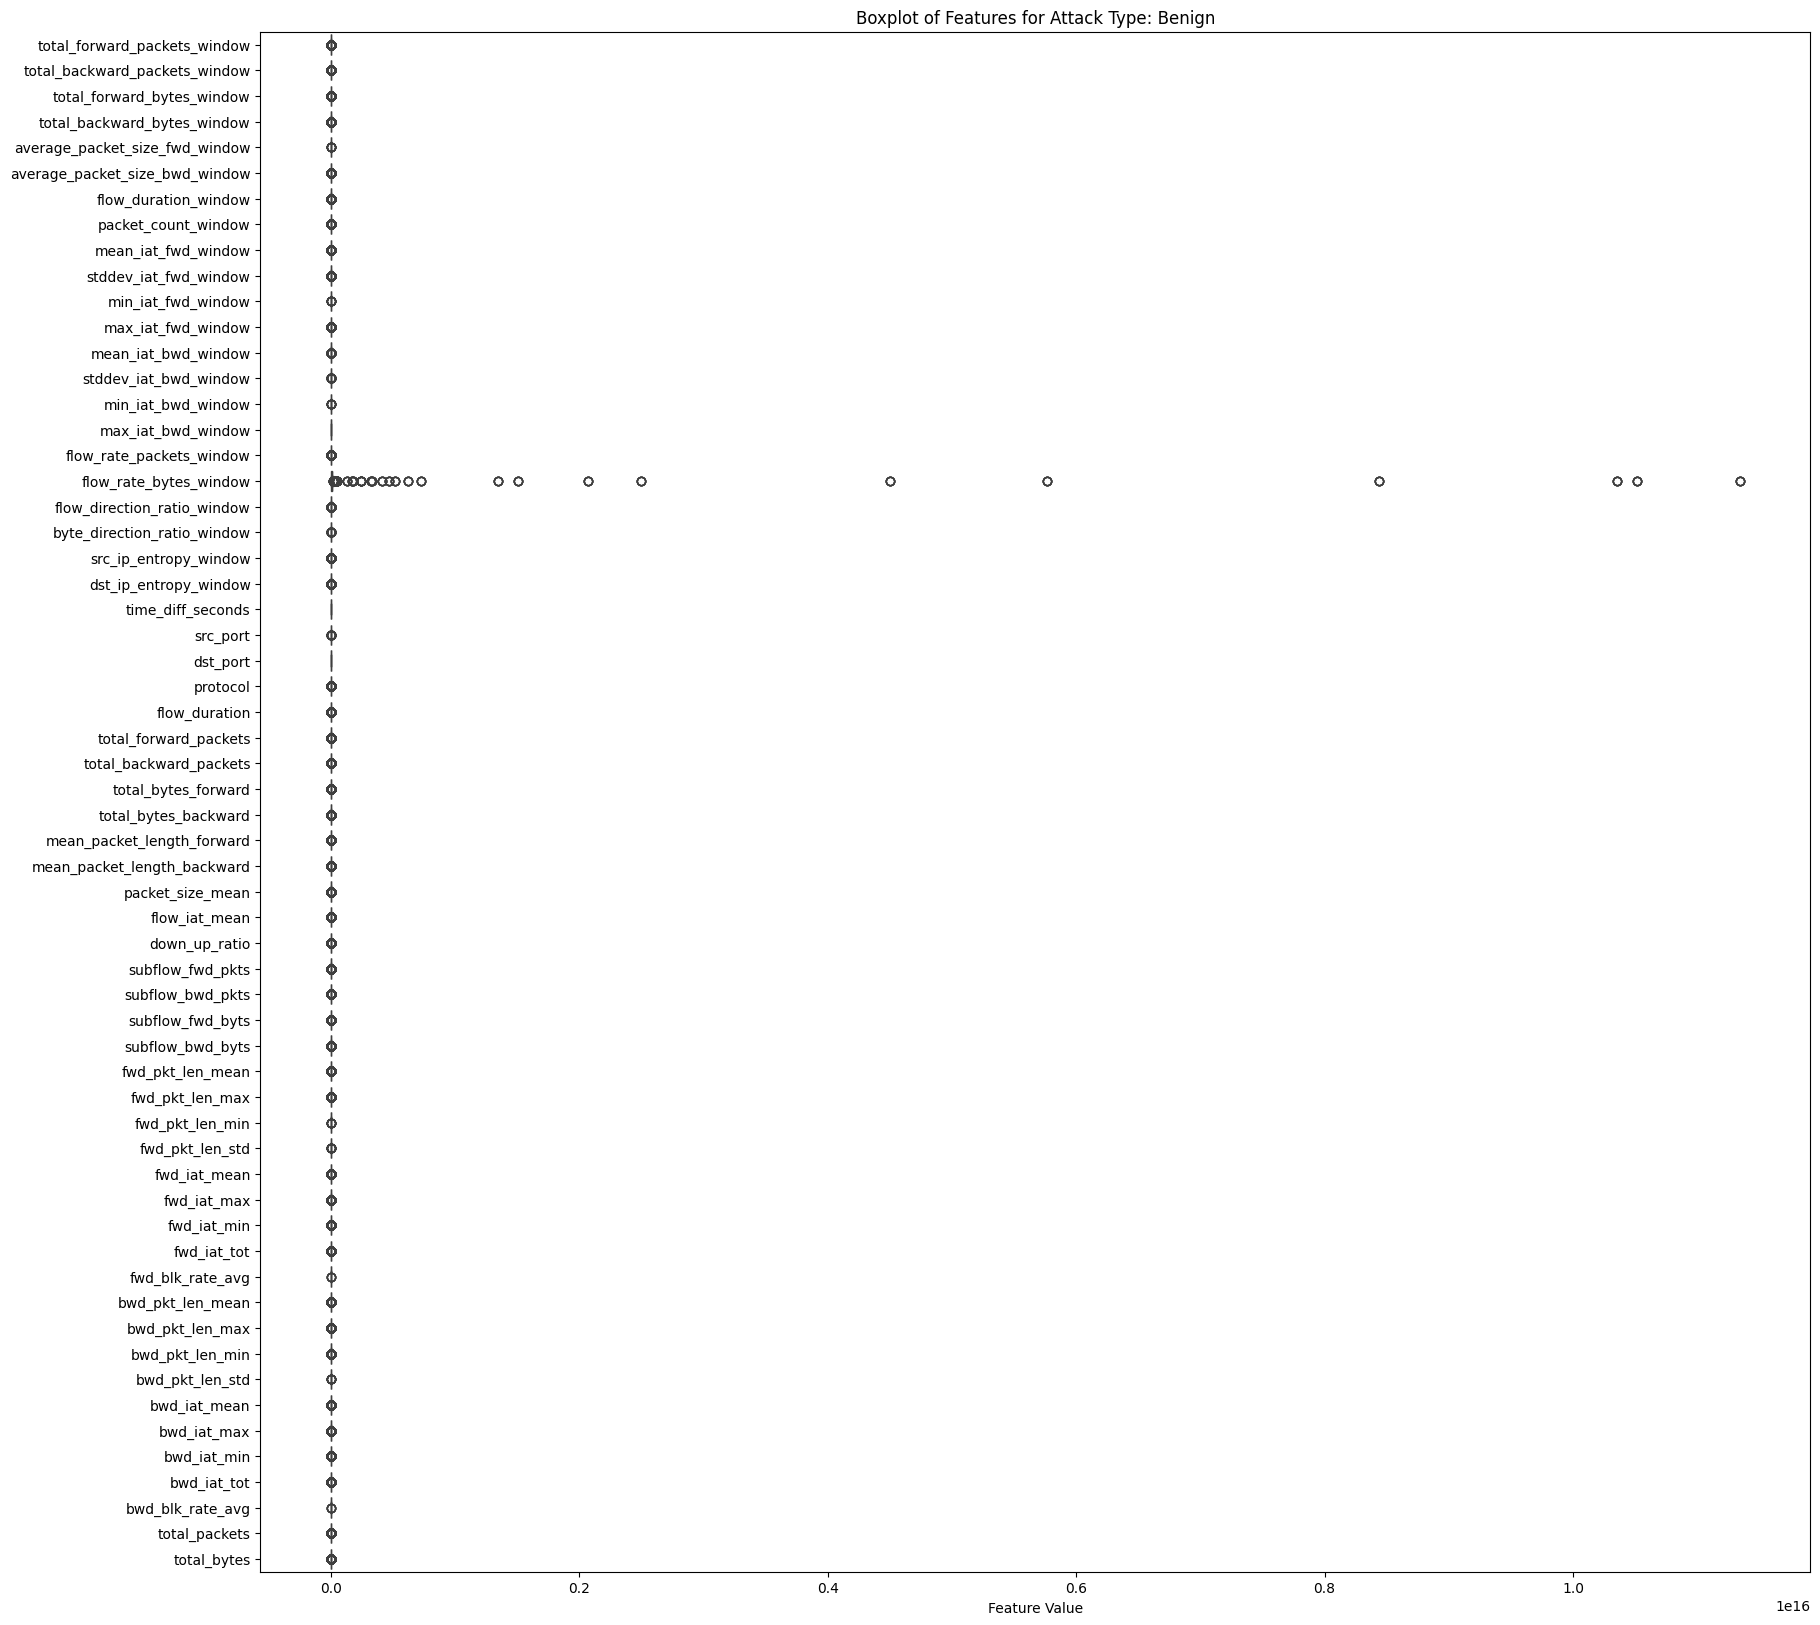

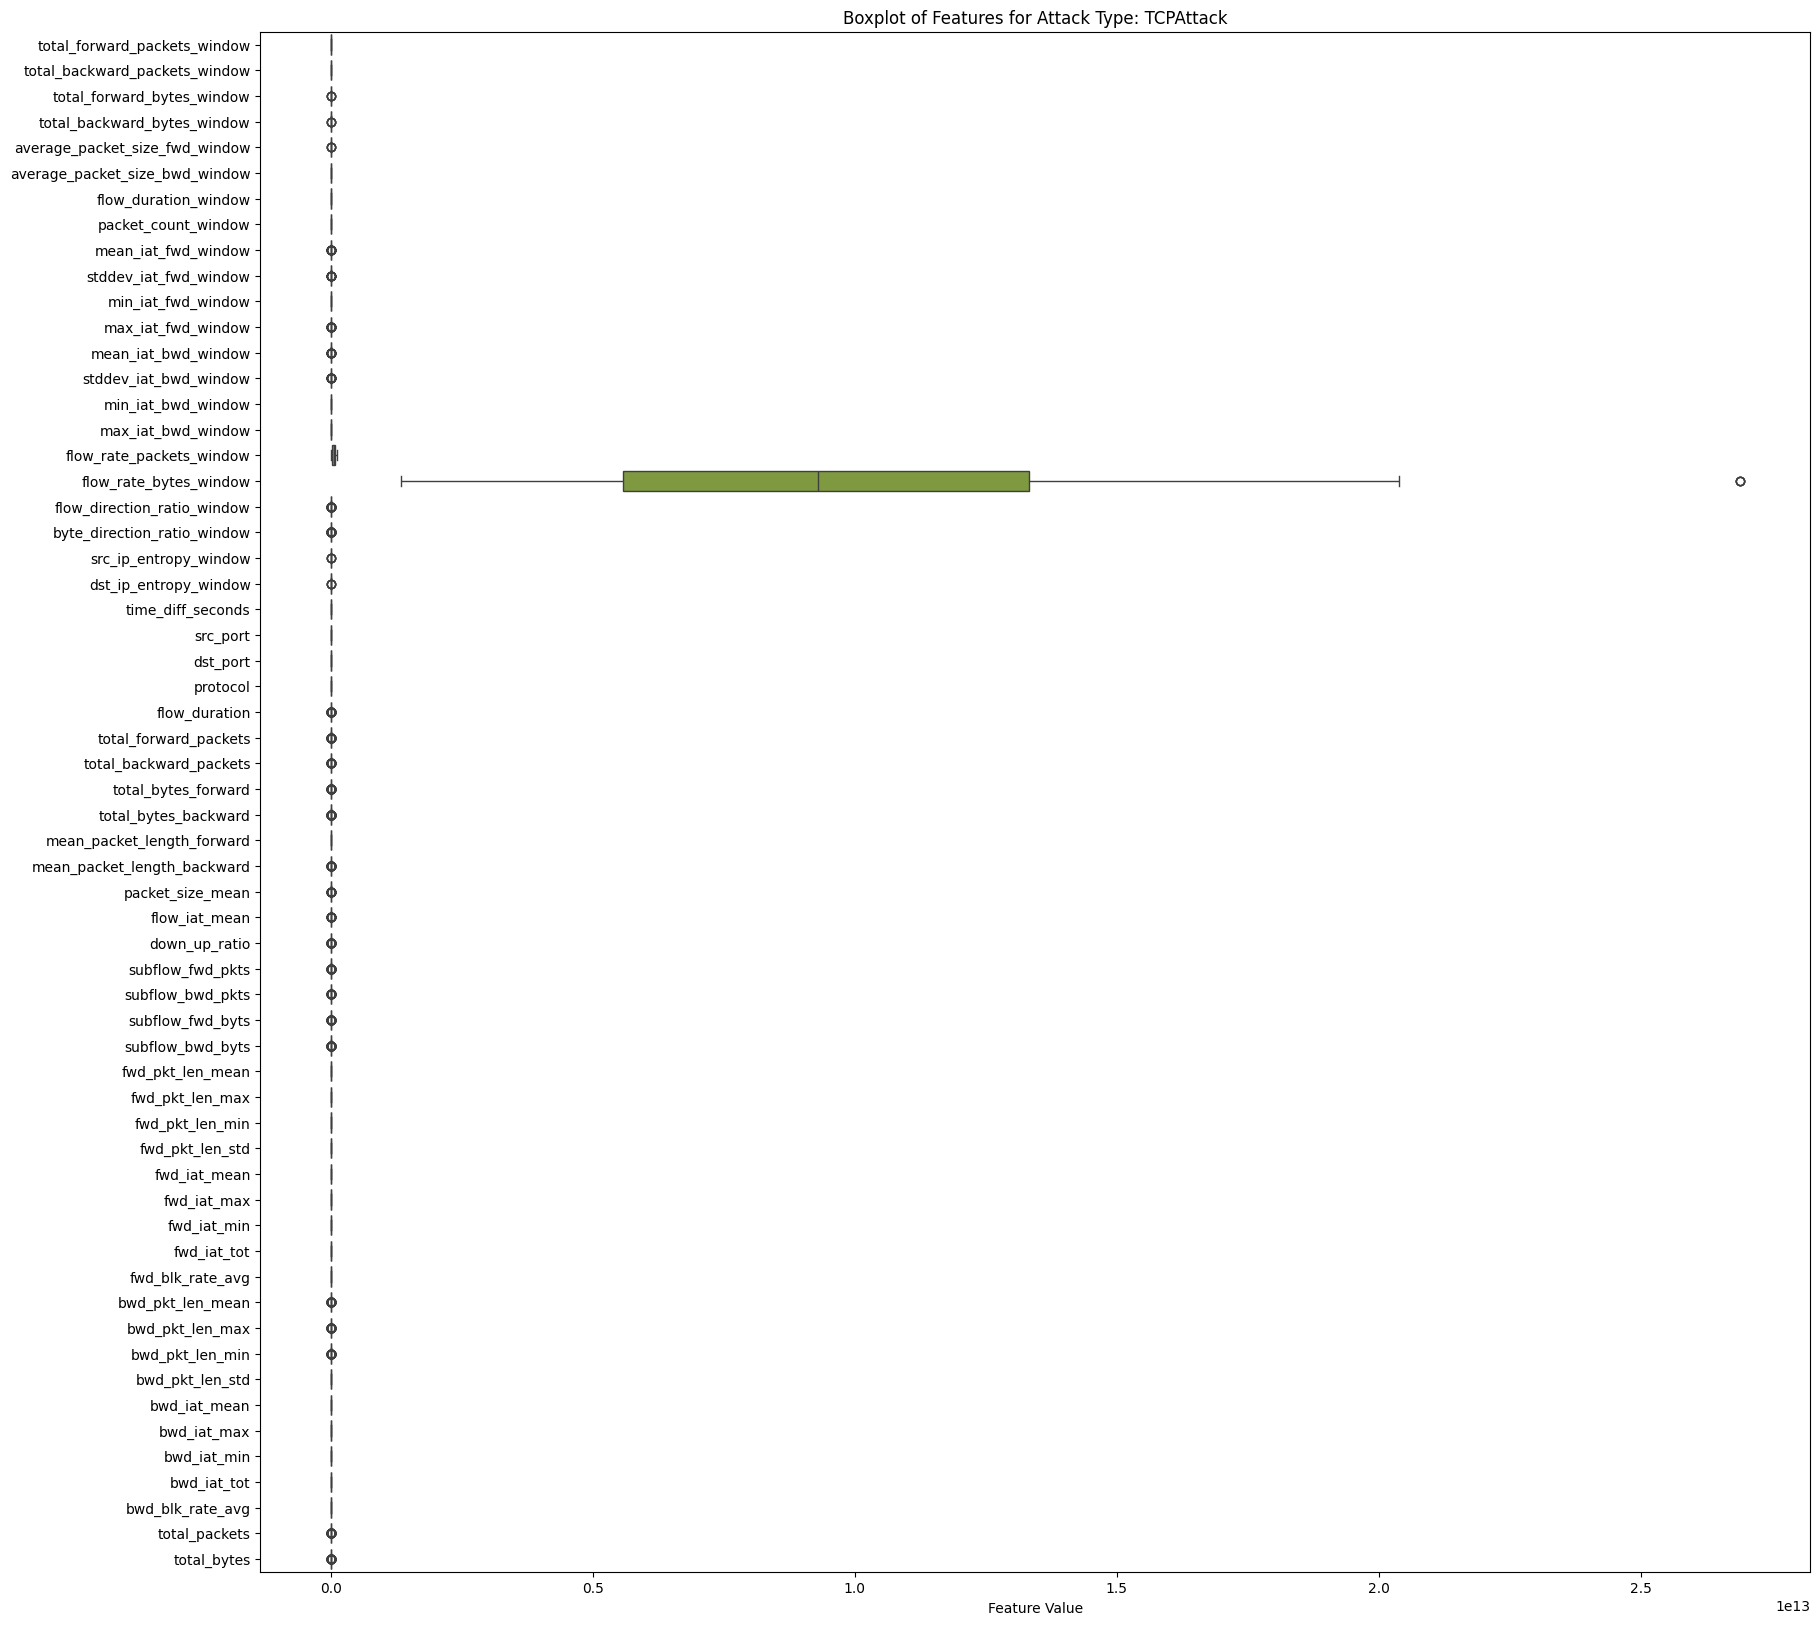

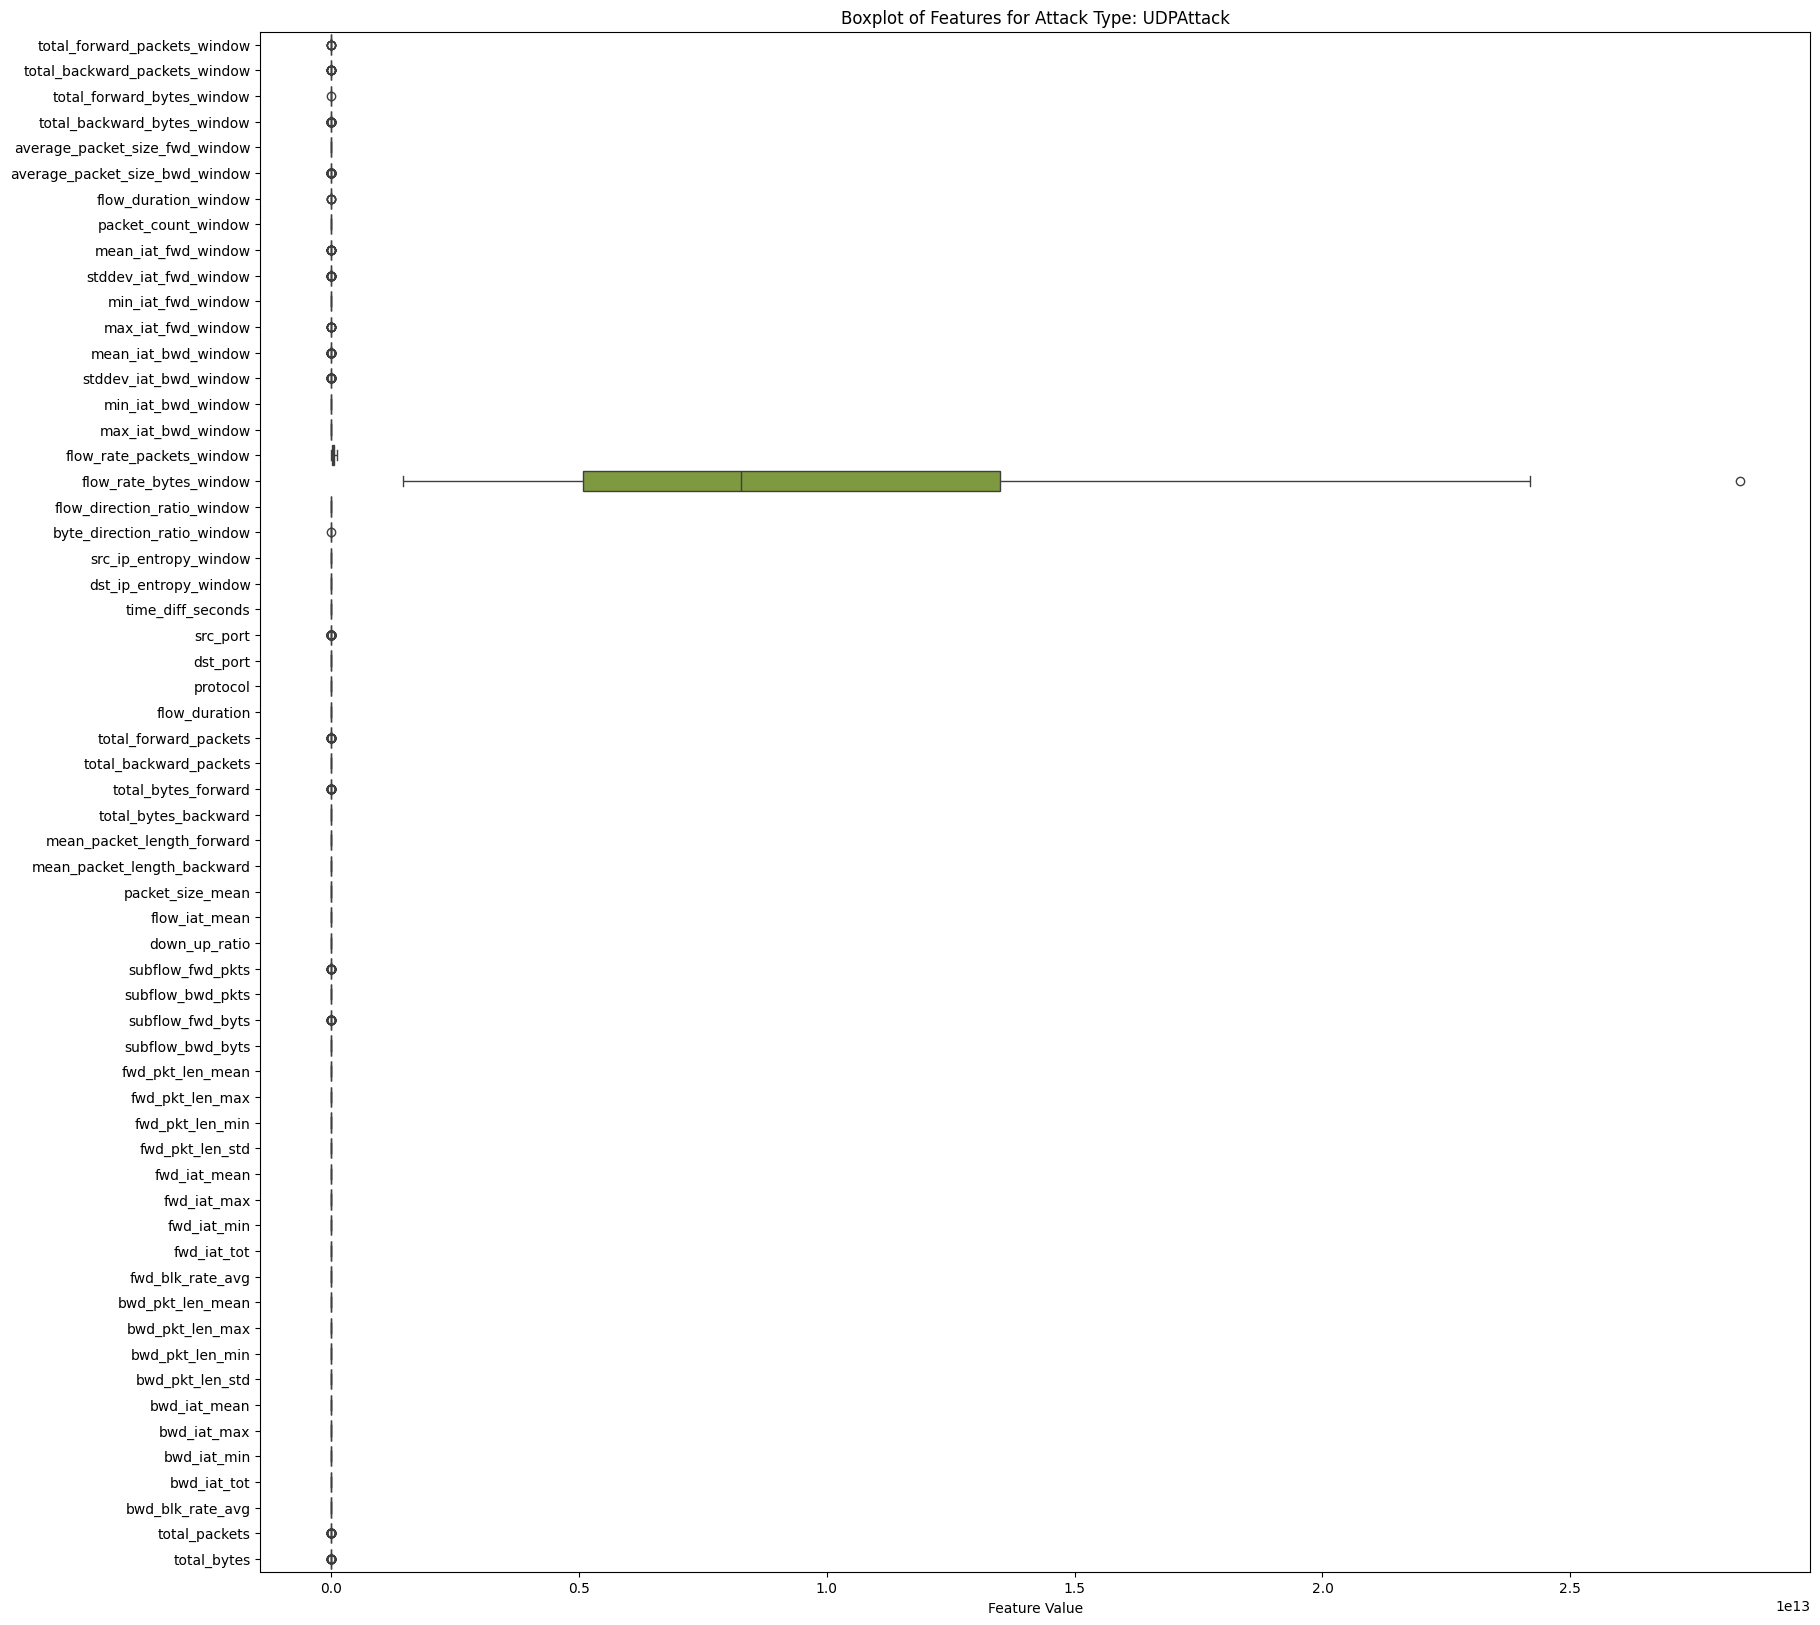

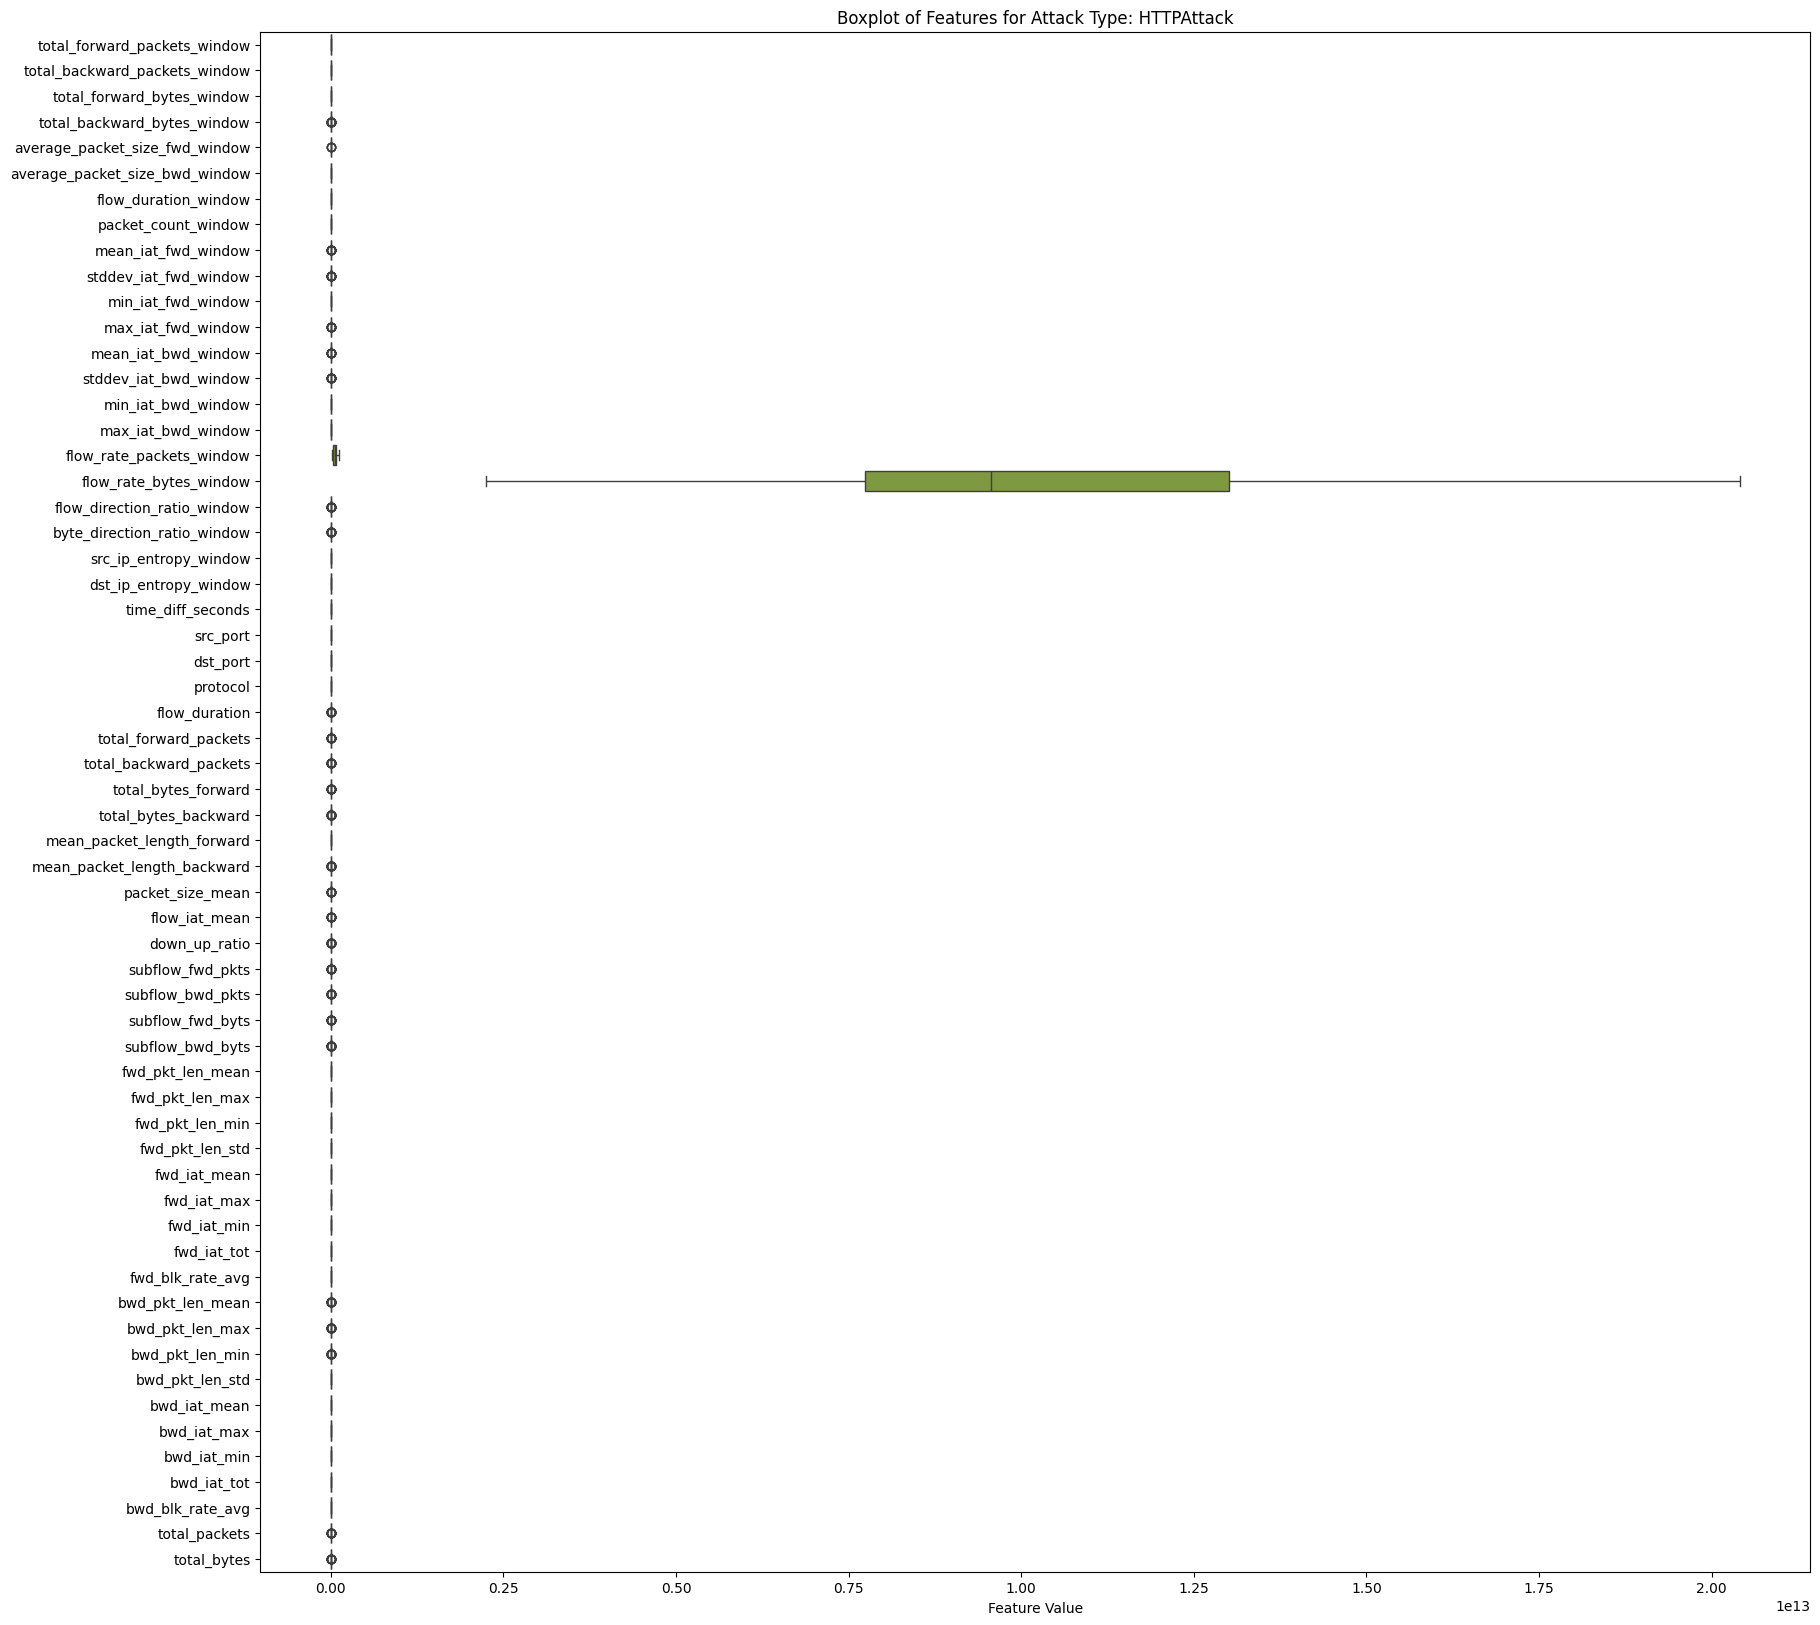

In [47]:
for attack_type in aggregated_data['Label'].unique():
    attack_data = aggregated_data[aggregated_data['Label'] == attack_type]

    plt.figure(figsize=(20, 20))

    sns.boxplot(data = attack_data.drop(columns = ['Label']), orient = 'h')

    plt.title(f'Boxplot of Features for Attack Type: {attack_type}')
    plt.xlabel('Feature Value')

    plt.show()

In [48]:
aggregated_data.groupby('Label').first()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,end_time_y
Label,,,,,,,,,,,,,,,,,,,,,
Benign,2024-08-13 08:01:00,2024-08-13 08:01:05,42,9,6232,671,134.525210,8.519608,208424228,17,...,0,66.085113,0.0,0,0,0,0.0,258398,256126628,2024-08-13 08:01:00
HTTPAttack,2024-08-13 13:59:00,2024-08-13 13:59:05,133,59,8922,3666,66.052910,48.793651,453916192,63,...,60,0.000000,0.0,0,0,0,0.0,258399,256126615,2024-08-13 13:59:00
TCPAttack,2024-08-13 09:56:00,2024-08-13 09:56:05,98,23,14371,1583,97.714815,30.751852,563678648,30,...,60,0.000000,0.0,0,0,0,0.0,258399,256126615,2024-08-13 09:56:00
UDPAttack,2024-08-13 11:58:00,2024-08-13 11:58:05,72,0,3972,0,55.166667,0.000000,0,72,...,0,0.000000,0.0,0,0,0,0.0,258398,256126549,2024-08-13 11:58:00
XMasAttack,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,60,NaN,0.0,0,0,0,0.0,258398,256126561,2024-08-13 08:00:00


In [49]:
# Data Preprocessing
# Dropping columns with only one unique value
num_unique = aggregated_data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
aggregated_data = aggregated_data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['time_diff', 'time_diff_seconds'], dtype='object')

In [50]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23986 entries, 0 to 23985
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   start_time                      23986 non-null  datetime64[ns]
 1   end_time_x                      23986 non-null  datetime64[ns]
 2   total_forward_packets_window    23986 non-null  int64         
 3   total_backward_packets_window   23986 non-null  int64         
 4   total_forward_bytes_window      23986 non-null  int64         
 5   total_backward_bytes_window     23986 non-null  int64         
 6   average_packet_size_fwd_window  23986 non-null  float64       
 7   average_packet_size_bwd_window  23986 non-null  float64       
 8   flow_duration_window            23986 non-null  int64         
 9   packet_count_window             23986 non-null  int64         
 10  mean_iat_fwd_window             23986 non-null  float64       
 11  st

In [52]:
drop_columns = [
    "start_time", "end_time_x", "src_ip", "dst_ip", "end_time_y"
   ]
aggregated_data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [53]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [54]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

fwd_pkt_len_std    10176
bwd_pkt_len_std    10176
dtype: int64


In [55]:
# selecting numeric attributes columns from aggregated_data
num_col = list(aggregated_data.select_dtypes(include='number').columns)
print(num_col)

['total_forward_packets_window', 'total_backward_packets_window', 'total_forward_bytes_window', 'total_backward_bytes_window', 'average_packet_size_fwd_window', 'average_packet_size_bwd_window', 'flow_duration_window', 'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window', 'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window', 'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window', 'flow_rate_packets_window', 'flow_rate_bytes_window', 'flow_direction_ratio_window', 'byte_direction_ratio_window', 'src_ip_entropy_window', 'dst_ip_entropy_window', 'src_port', 'dst_port', 'protocol', 'flow_duration', 'total_forward_packets', 'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward', 'mean_packet_length_forward', 'mean_packet_length_backward', 'packet_size_mean', 'flow_iat_mean', 'down_up_ratio', 'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_bwd_byts', 'fwd_pkt_len_mean', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd

In [56]:
# Checking for infinity or NaN values and replacing them with the median value of the column
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in num_col:
    if aggregated_data[col].isnull().sum() > 0:
        median_value = aggregated_data[col].median()
        aggregated_data[col] = aggregated_data[col].fillna(median_value)  # Direct assignment to avoid warning

In [57]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [58]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [59]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.84%


In [60]:
# Exploring Explained Variance
print(ipca.explained_variance_ratio_)

[0.26218519 0.1323922  0.10820952 0.09481001 0.07877488 0.05882655
 0.04936945 0.03761724 0.02898659 0.02626931 0.01847108 0.01552033
 0.01450503 0.01016661 0.00954773 0.00879937 0.00820643 0.00726391
 0.00668799 0.00584876 0.00449372 0.00395834 0.00194905 0.00183453
 0.00127127 0.00081527 0.00076027 0.0004686  0.00037962]


In [62]:
# Exploring our PCA Data
expl_var = ipca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()),
    columns=['IPCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('IPCA').mul(100).round(1)
print(df_expl_var)

      Explained Variance (%)  Total Explained Variance (%)
IPCA                                                      
1                       26.2                          26.2
2                       13.2                          39.5
3                       10.8                          50.3
4                        9.5                          59.8
5                        7.9                          67.6
6                        5.9                          73.5
7                        4.9                          78.5
8                        3.8                          82.2
9                        2.9                          85.1
10                       2.6                          87.7
11                       1.8                          89.6
12                       1.6                          91.1
13                       1.5                          92.6
14                       1.0                          93.6
15                       1.0                          94

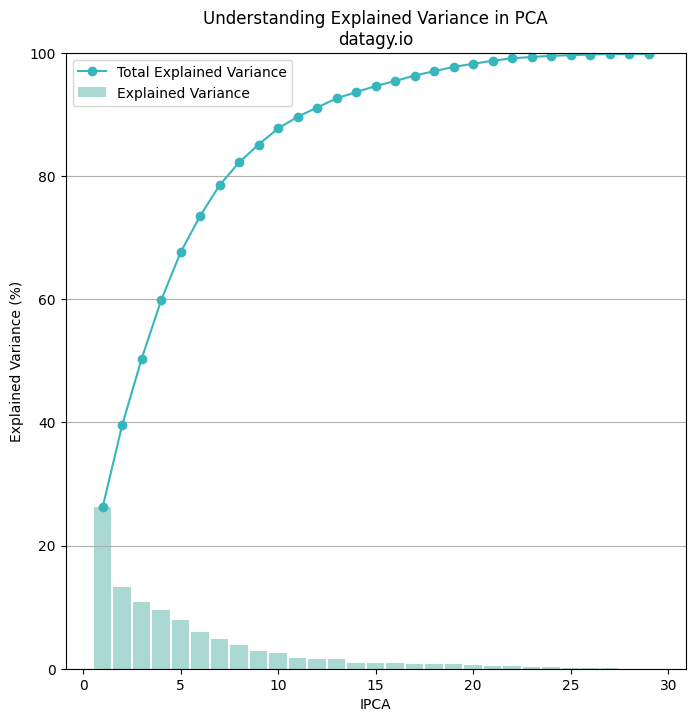

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('IPCA')
plt.grid(True, axis='y')
plt.title('Understanding Explained Variance in PCA\ndatagy.io')
plt.legend()

In [64]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Label'] = attacks.values

In [65]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,Label
0,0.754862,0.792607,-5.046810,7.278958,4.568703,-1.591925,1.959515,-0.446673,-0.301444,0.024018,...,2.126535,-0.806710,-0.522950,0.463925,-1.187569,1.399461,-0.083519,-1.140633,-0.381070,XMasAttack
1,0.798593,0.239757,-1.326154,4.461649,2.471421,-2.604250,-0.622555,-0.419662,2.690507,-4.176509,...,-1.040473,0.823280,0.775456,-0.904599,-0.475565,0.326584,0.076149,-0.748874,-1.082341,XMasAttack
2,0.798593,0.239757,-1.326154,4.461649,2.471421,-2.604250,-0.622555,-0.419662,2.690507,-4.176509,...,-1.040473,0.823280,0.775456,-0.904599,-0.475565,0.326584,0.076149,-0.748874,-1.082341,XMasAttack
3,0.798593,0.239757,-1.326154,4.461649,2.471421,-2.604250,-0.622555,-0.419662,2.690507,-4.176509,...,-1.040473,0.823280,0.775456,-0.904599,-0.475565,0.326584,0.076149,-0.748874,-1.082341,XMasAttack
4,0.798593,0.239757,-1.326154,4.461649,2.471421,-2.604250,-0.622555,-0.419662,2.690507,-4.176509,...,-1.040473,0.823280,0.775456,-0.904599,-0.475565,0.326584,0.076149,-0.748874,-1.082341,XMasAttack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23981,-0.545538,0.242022,-1.583870,-1.153101,-2.302803,-0.507729,-3.669099,-1.044755,1.071719,-1.729277,...,0.708016,-0.493982,-0.598765,0.007435,-0.168605,-0.121424,-0.002475,-0.093048,-0.012277,Benign
23982,-0.545538,0.242022,-1.583870,-1.153101,-2.302803,-0.507729,-3.669099,-1.044755,1.071719,-1.729277,...,0.708016,-0.493982,-0.598765,0.007435,-0.168605,-0.121424,-0.002475,-0.093048,-0.012277,Benign
23983,-0.545538,0.242022,-1.583870,-1.153101,-2.302803,-0.507729,-3.669099,-1.044755,1.071719,-1.729277,...,0.708016,-0.493982,-0.598765,0.007435,-0.168605,-0.121424,-0.002475,-0.093048,-0.012277,Benign
23984,-0.545538,0.242022,-1.583870,-1.153101,-2.302803,-0.507729,-3.669099,-1.044755,1.071719,-1.729277,...,0.708016,-0.493982,-0.598765,0.007435,-0.168605,-0.121424,-0.002475,-0.093048,-0.012277,Benign


In [66]:
# Machine Learning  Models
from sklearn.model_selection import cross_val_score

In [67]:
# Creating a balanced dataset for Binary Classification
normal = new_data.loc[new_data['Label'] == 'Benign']
intrusions = new_data.loc[new_data['Label'] != 'Benign']

normal = normal.sample(n = len(intrusions), replace = False)

ids_data = pd.concat([intrusions, normal])
ids_data['Label'] = np.where((ids_data['Label'] == 'Benign'), 0, 1)
bin_class_data = ids_data.sample(n = 1650)

print(bin_class_data['Label'].value_counts())

Label
0    825
1    825
Name: count, dtype: int64


In [68]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_bin_class = bin_class_data.drop('Label', axis = 1)
y_bin_class = bin_class_data['Label']

X_train_bin_class, X_test_bin_class, y_train_bin_class, y_test_bin_class = train_test_split(X_bin_class, y_bin_class, test_size = 0.25, random_state = 0)

In [69]:
# Logistic Regression (Binary Classification)
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga')
lr1.fit(X_train_bin_class, y_train_bin_class)

cv_lr1 = cross_val_score(lr1, X_train_bin_class, y_train_bin_class, cv = 5)
print('Logistic regression Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr1)))
print(f'\nMean cross-validation score: {cv_lr1.mean():.2f}')

Logistic regression Model 1

Cross-validation scores: 1.0, 0.9959677419354839, 1.0, 1.0, 1.0

Mean cross-validation score: 1.00


In [70]:
print('Logistic Regression Model 1 coefficients:')
print(*lr1.coef_, sep = ', ')
print('\nLogistic Regression Model 1 intercept:', *lr1.intercept_)


Logistic Regression Model 1 coefficients:
[-0.00869825  0.08824916 -0.75820033  0.54416889  0.15441112 -0.2662713
 -0.03342348  0.09043896  0.55859932 -1.01799142 -0.5484397  -0.07266196
 -0.7484406  -0.24959266 -0.05792629 -0.17499277 -0.11701319 -0.29749936
  0.0281306  -0.14545666 -0.06249072  0.04159819 -0.40568534 -0.43673655
 -0.0103843   0.05521831  0.0028569   0.01236938 -0.05778376]

Logistic Regression Model 1 intercept: -5.591334966381124


In [71]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
y_pred = lr1.predict(X_test_bin_class)

In [72]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [73]:
# Precision, Recall, and F1-Score
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [74]:
lr2 = LogisticRegression(max_iter = 15000, solver = 'sag', C = 100, random_state = 0)
lr2.fit(X_train_bin_class, y_train_bin_class)

cv_lr2 = cross_val_score(lr2, X_train_bin_class, y_train_bin_class, cv = 5)
print('Logistic regression Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr2)))
print(f'\nMean cross-validation score: {cv_lr2.mean():.2f}')

Logistic regression Model 2

Cross-validation scores: 1.0, 1.0, 0.9919028340080972, 1.0, 1.0

Mean cross-validation score: 1.00


In [75]:
print('Logistic Regression Model 2 coefficients:')
print(*lr2.coef_, sep = ', ')
print('\nLogistic Regression Model 2 intercept:', *lr2.intercept_)

Logistic Regression Model 2 coefficients:
[ 0.31365296  0.30059995 -0.65712528  0.54477018  0.28115527 -0.40767989
 -0.19501797  0.26602541  0.99715249 -1.83266497 -1.67635775 -0.57103105
 -1.64329626 -0.53492846 -0.25638726 -0.47464335 -0.17103201 -0.86857456
 -0.2335749  -0.15726293 -0.33618433  0.1113096  -1.02914089 -1.06762707
  0.07621738  0.18523573  0.11419211  0.0339577  -0.26123769]

Logistic Regression Model 2 intercept: -6.923670038779663


In [76]:
y_pred = lr2.predict(X_test_bin_class)

In [77]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [78]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [79]:
# Deep Learning model
# Build the binary classification model
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout

model = Sequential([
    Input(shape=(X_train_bin_class.shape[1],)),  # Input layer with the shape of input data
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [80]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
# Train the model
history = model.fit(X_train_bin_class, y_train_bin_class, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6480 - loss: 0.5777 - val_accuracy: 0.8387 - val_loss: 0.3766
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8558 - loss: 0.3606 - val_accuracy: 0.9556 - val_loss: 0.2112
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9438 - loss: 0.2056 - val_accuracy: 0.9960 - val_loss: 0.1044
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.1286 - val_accuracy: 1.0000 - val_loss: 0.0467
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0739 - val_accuracy: 1.0000 - val_loss: 0.0232
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss

In [82]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_bin_class, y_test_bin_class)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8243e-05
Test Loss: 5.9453537687659264e-05, Test Accuracy: 1.0


In [83]:
# Predict the test set
y_pred = (model.predict(X_test_bin_class) > 0.5).astype(int)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [84]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [85]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [86]:
# Support Vector Machine (Binary Classification)
from sklearn.svm import SVC

svm1 = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm1.fit(X_train_bin_class, y_train_bin_class)

cv_svm1 = cross_val_score(svm1, X_train_bin_class, y_train_bin_class, cv = 5)
print('Support Vector Machine Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_svm1)))
print(f'\nMean cross-validation score: {cv_svm1.mean():.2f}')

Support Vector Machine Model 1

Cross-validation scores: 1.0, 1.0, 1.0, 1.0, 1.0

Mean cross-validation score: 1.00


In [87]:
y_pred_svm = svm1.predict(X_test_bin_class)

In [88]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_svm)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [89]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_svm))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [90]:
svm2 = SVC(kernel = 'rbf', C = 1, gamma = 0.1, random_state = 0, probability = True)
svm2.fit(X_train_bin_class, y_train_bin_class)

cv_svm2 = cross_val_score(svm2, X_train_bin_class, y_train_bin_class, cv = 5)
print('Support Vector Machine Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_svm2)))
print(f'\nMean cross-validation score: {cv_svm2.mean():.2f}')

Support Vector Machine Model 2

Cross-validation scores: 0.9959677419354839, 0.9919354838709677, 0.9919028340080972, 0.9878542510121457, 0.9959514170040485

Mean cross-validation score: 0.99


In [91]:
y_pred_svm1 = svm2.predict(X_test_bin_class)

In [92]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_svm1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [93]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_svm1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [94]:
print('SVM Model 1 intercept:', *svm1.intercept_)
print('SVM Model 2 intercept:', *svm2.intercept_)

SVM Model 1 intercept: -1.1340862480622544
SVM Model 2 intercept: -0.018201571289610686


In [95]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_bin_class, y_train_bin_class)

# Cross-validation for Decision Tree
cv_dt = cross_val_score(dt, X_train_bin_class, y_train_bin_class, cv=5)
print('Decision Tree Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_dt))}')
print(f'Mean cross-validation score: {cv_dt.mean():.2f}')

Decision Tree Classifier
Cross-validation scores: 0.9879032258064516, 0.9919354838709677, 0.9838056680161943, 0.9919028340080972, 1.0
Mean cross-validation score: 0.99


In [96]:
y_pred_dt = dt.predict(X_test_bin_class)

In [97]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_dt)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[212   1]
 [  1 199]]


In [98]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       0.99      0.99      0.99       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [99]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_bin_class, y_train_bin_class)

# Cross-validation for Random Forest
cv_rf = cross_val_score(rf, X_train_bin_class, y_train_bin_class, cv=5)
print('Random Forest Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_rf))}')
print(f'Mean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Classifier
Cross-validation scores: 1.0, 1.0, 1.0, 1.0, 1.0
Mean cross-validation score: 1.00


In [100]:
y_pred_rf = rf.predict(X_test_bin_class)

In [101]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_rf)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [102]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [103]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_bin_class, y_train_bin_class)

cv_knn = cross_val_score(knn, X_train_bin_class, y_train_bin_class, cv=5)
print('K-Nearest Neighbors Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_knn))}')
print(f'Mean cross-validation score: {cv_knn.mean():.2f}')

K-Nearest Neighbors Classifier
Cross-validation scores: 1.0, 1.0, 1.0, 1.0, 1.0
Mean cross-validation score: 1.00


In [104]:
y_pred_knn = knn.predict(X_test_bin_class)

In [105]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_knn)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[213   0]
 [  0 200]]


In [106]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       200

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [107]:
# Creating a Balanced Dataset for Multi-class Classification
new_data['Label'].value_counts()

,count
Label,
Benign,23156
TCPAttack,270
UDPAttack,265
HTTPAttack,165
XMasAttack,130


In [109]:
class_counts = new_data['Label'].value_counts()
selected_classes = class_counts[class_counts > 129]
class_names = selected_classes.index
selected = new_data[new_data['Label'].isin(class_names)]

dfs = []
for name in class_names:
  multi_class = selected[selected['Label'] == name]
  if len(multi_class) > 1000:
    multi_class = multi_class.sample(n = 1000, random_state = 0)

  dfs.append(multi_class)

multi_class = pd.concat(dfs, ignore_index = True)
multi_class['Label'].value_counts()

,count
Label,
Benign,1000
TCPAttack,270
UDPAttack,265
HTTPAttack,165
XMasAttack,130


In [110]:
from imblearn.over_sampling import SMOTE

X = multi_class.drop('Label', axis=1)
y = multi_class['Label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

multi_class_data = pd.DataFrame(X_upsampled)
multi_class_data['Label'] = y_upsampled
multi_class_data = multi_class_data.sample(frac=1)

multi_class_data['Label'].value_counts()

,count
Label,
UDPAttack,1000
HTTPAttack,1000
TCPAttack,1000
XMasAttack,1000
Benign,1000


In [111]:
features = multi_class_data.drop('Label', axis = 1)
labels = multi_class_data['Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [112]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [113]:
num_classes = len(y_train.unique())

In [114]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))  # Hidden Layer 1
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(64, activation='relu'))  # Hidden Layer 2
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(num_classes, activation='softmax'))

In [115]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,421 (48.52 KB)

 Trainable params: 12,421 (48.52 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the string labels to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the integer labels
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [118]:
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4398 - loss: 1.4436 - val_accuracy: 0.8104 - val_loss: 0.3826
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7682 - loss: 0.4906 - val_accuracy: 0.8192 - val_loss: 0.3004
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7814 - loss: 0.3833 - val_accuracy: 0.8288 - val_loss: 0.2837
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8060 - loss: 0.3319 - val_accuracy: 0.8000 - val_loss: 0.2837
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8214 - loss: 0.2988 - val_accuracy: 0.8144 - val_loss: 0.2801
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8160 - loss: 0.2926 - val_accuracy: 0.8232 - val_loss: 0.2765
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8165 - loss: 0.2915 - val_accuracy: 0.8416 - val_loss: 0.2724
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8204 - loss: 0.2936 - val_accuracy: 0.

In [119]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9840 - loss: 0.0646
Test Loss: 0.060926564037799835, Test Accuracy: 0.9807999730110168


In [120]:
y_pred_prob = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [121]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

In [122]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[250   0   0   0   0]
 [  0 233  17   0   0]
 [  0   7 252   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [123]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       0.97      0.93      0.95       250
           2       0.94      0.97      0.95       259
           3       1.00      1.00      1.00       242
           4       1.00      1.00      1.00       249

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250



In [124]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 10, max_depth = 6, max_features = None, random_state = 0)
rf1.fit(X_train, y_train)

cv_rf1 = cross_val_score(rf1, X_train, y_train, cv = 5)
print('Random Forest Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf1)))
print(f'\nMean cross-validation score: {cv_rf1.mean():.2f}')

Random Forest Model 1

Cross-validation scores: 0.92, 0.9466666666666667, 0.9466666666666667, 0.9533333333333334, 0.9546666666666667

Mean cross-validation score: 0.94


In [125]:
y_pred_rfc = rf1.predict(X_test)

In [126]:
conf_matrix = confusion_matrix(y_test, y_pred_rfc)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[248   1   1   0   0]
 [  0 219  31   0   0]
 [  0  23 236   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [127]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00       250
  HTTPAttack       0.90      0.88      0.89       250
   TCPAttack       0.88      0.91      0.90       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       1.00      1.00      1.00       249

    accuracy                           0.96      1250
   macro avg       0.96      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250



In [128]:
rf2 = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf2.fit(X_train, y_train)

cv_rf2 = cross_val_score(rf2, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf2)))
print(f'\nMean cross-validation score: {cv_rf2.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.984, 0.9813333333333333, 0.9746666666666667, 0.9866666666666667, 0.9893333333333333

Mean cross-validation score: 0.98


In [129]:
y_pred_rfc1 = rf2.predict(X_test)

In [130]:
conf_matrix = confusion_matrix(y_test, y_pred_rfc1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[249   0   1   0   0]
 [  0 231  19   0   0]
 [  0   6 253   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [131]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       250
  HTTPAttack       0.97      0.92      0.95       250
   TCPAttack       0.93      0.98      0.95       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       1.00      1.00      1.00       249

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250



In [132]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt1 = DecisionTreeClassifier(max_depth = 6)
dt1.fit(X_train, y_train)

cv_dt1 = cross_val_score(dt1, X_train, y_train, cv = 5)
print('Decision Tree Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt1)))
print(f'\nMean cross-validation score: {cv_dt1.mean():.2f}')

Decision Tree Model 1

Cross-validation scores: 0.9506666666666667, 0.9506666666666667, 0.94, 0.9466666666666667, 0.9533333333333334

Mean cross-validation score: 0.95


In [133]:
y_pred_dt1 = dt1.predict(X_test)

In [134]:
conf_matrix = confusion_matrix(y_test, y_pred_dt1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[246   1   2   1   0]
 [  0 223  27   0   0]
 [  0  41 218   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [135]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dt1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99       250
  HTTPAttack       0.84      0.89      0.87       250
   TCPAttack       0.88      0.84      0.86       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       1.00      1.00      1.00       249

    accuracy                           0.94      1250
   macro avg       0.94      0.94      0.94      1250
weighted avg       0.94      0.94      0.94      1250



In [136]:
dt2 = DecisionTreeClassifier(max_depth = 8)
dt2.fit(X_train, y_train)

cv_dt2 = cross_val_score(dt2, X_train, y_train, cv = 5)
print('Decision Tree Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt2)))
print(f'\nMean cross-validation score: {cv_dt2.mean():.2f}')

Decision Tree Model 2

Cross-validation scores: 0.968, 0.9733333333333334, 0.9666666666666667, 0.98, 0.9813333333333333

Mean cross-validation score: 0.97


In [137]:
y_pred_dt2 = dt2.predict(X_test)

In [138]:
conf_matrix = confusion_matrix(y_test, y_pred_dt2)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[246   2   1   1   0]
 [  0 231  19   0   0]
 [  0  11 248   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [139]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dt2))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99       250
  HTTPAttack       0.95      0.92      0.94       250
   TCPAttack       0.93      0.96      0.94       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       1.00      1.00      1.00       249

    accuracy                           0.97      1250
   macro avg       0.97      0.97      0.97      1250
weighted avg       0.97      0.97      0.97      1250



In [140]:
# K Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors = 16)
knn1.fit(X_train, y_train)

cv_knn1 = cross_val_score(knn1, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn1)))
print(f'\nMean cross-validation score: {cv_knn1.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9706666666666667, 0.9613333333333334, 0.952, 0.972, 0.98

Mean cross-validation score: 0.97


In [141]:
y_pred_knn1 = knn1.predict(X_test)

In [142]:
conf_matrix = confusion_matrix(y_test, y_pred_knn1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[248   0   0   0   2]
 [  0 231  19   0   0]
 [  0   3 256   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [143]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00       250
  HTTPAttack       0.99      0.92      0.95       250
   TCPAttack       0.93      0.99      0.96       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       0.99      1.00      1.00       249

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250



In [144]:
knn2 = KNeighborsClassifier(n_neighbors = 8)
knn2.fit(X_train, y_train)

cv_knn2 = cross_val_score(knn2, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn2)))
print(f'\nMean cross-validation score: {cv_knn2.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9893333333333333, 0.988, 0.9813333333333333, 0.9906666666666667, 0.992

Mean cross-validation score: 0.99


In [146]:
y_pred_knn2 = knn2.predict(X_test)

In [147]:
conf_matrix = confusion_matrix(y_test, y_pred_knn2)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[250   0   0   0   0]
 [  0 244   6   0   0]
 [  0   3 256   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 249]]


In [148]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn2))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       250
  HTTPAttack       0.99      0.98      0.98       250
   TCPAttack       0.98      0.99      0.98       259
   UDPAttack       1.00      1.00      1.00       242
  XMasAttack       1.00      1.00      1.00       249

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250

